# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [82]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [286]:
noise = .2

#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

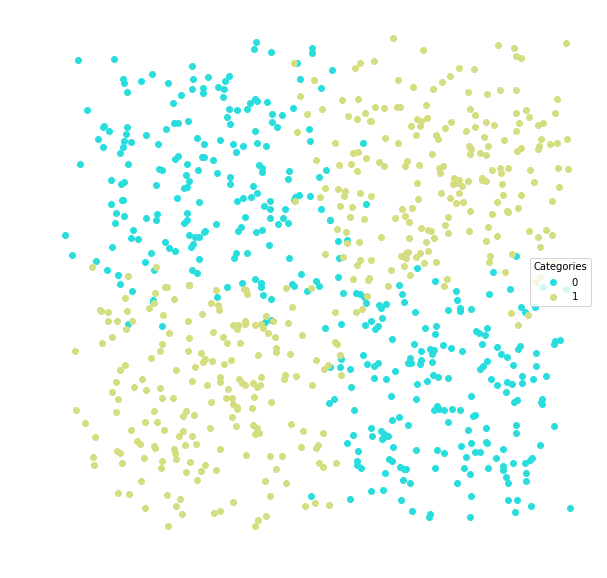

In [38]:
lucem_illud.plotter(dfTrain)

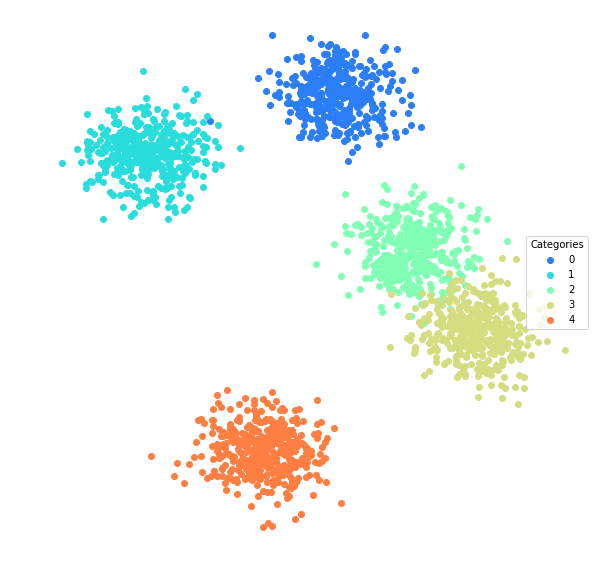

In [113]:
lucem_illud.plotter(artificialData['multiBlobs02'][0])

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [39]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [40]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [43]:
lucem_illud.evaluateClassifier(clf, dfTest)

AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
0         0.890865           0.866742        0.11   0.912621  0.878505
1         0.890865           0.827175        0.11   0.865979  0.903226

This lets us look at which classes do better:

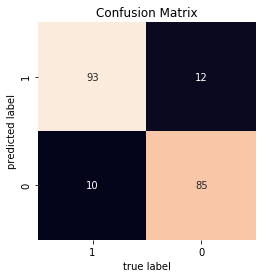

In [7]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

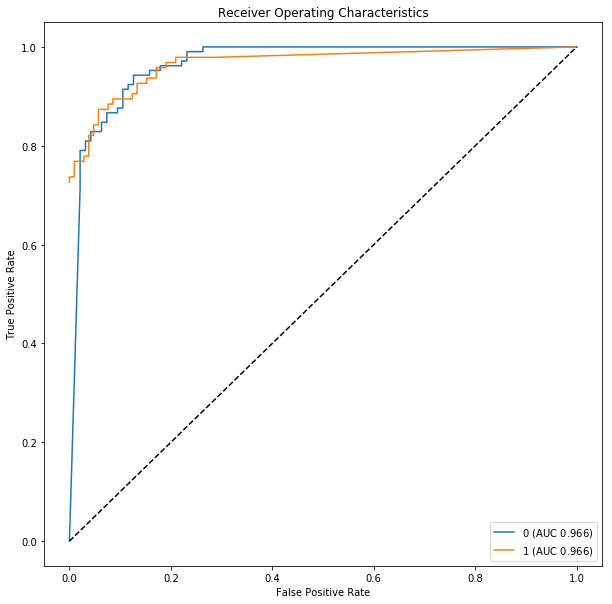

In [8]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

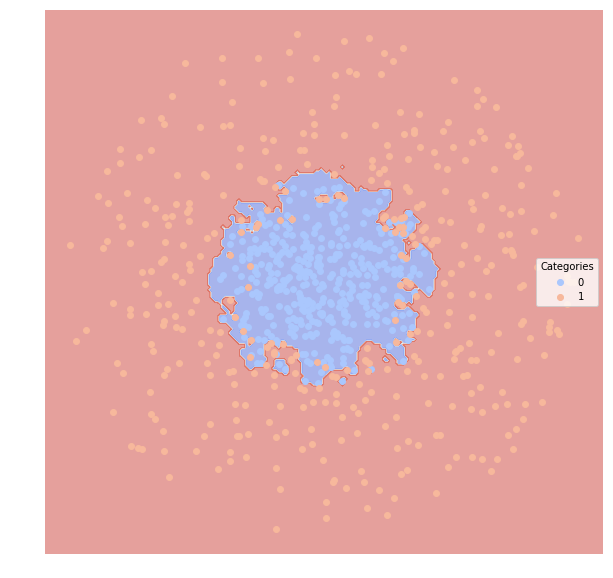

In [9]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [10]:
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Reddit data
Converting to vectors


In [11]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [12]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None)

In [13]:
lucem_illud.evaluateClassifier(clf, dfTest)

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                      
Tales From Tech Support  0.845290           0.700955    0.097179   0.867647   
Weeaboo Tales            0.867787           0.575651    0.159875   0.605263   
Bad Roommates            0.783388           0.526200    0.181818   0.634409   
Relationships            0.616501           0.349971    0.231975   0.568182   

                           Recall  
Category                           
Tales From Tech Support  0.728395  
Weeaboo Tales            0.920000  
Bad Roommates            0.710843  
Relationships            0.312500

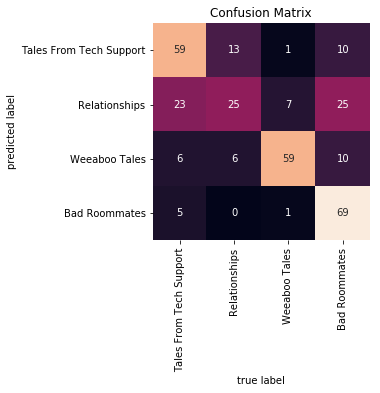

In [14]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

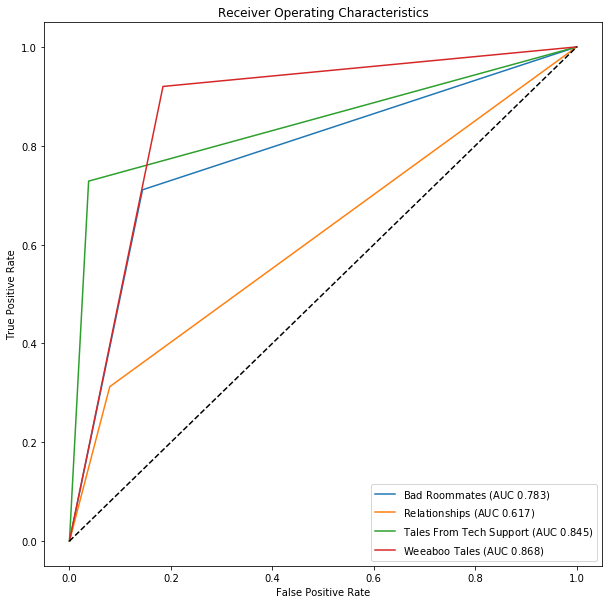

In [15]:
lucem_illud.plotMultiROC(clf, dfTest)

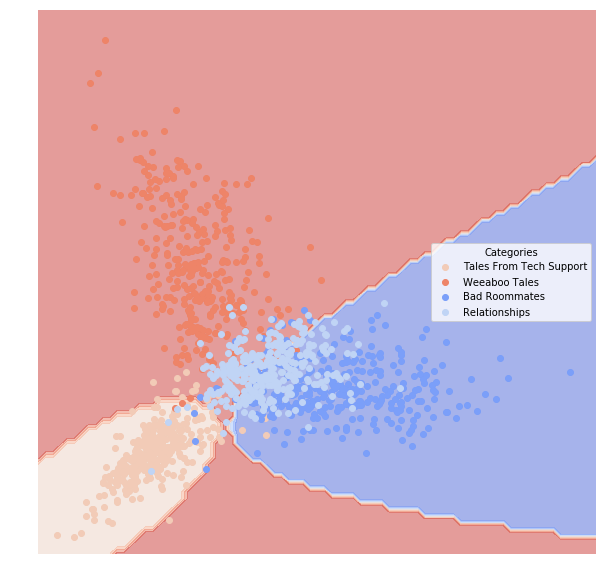

In [16]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

# Generate 10 distinct artificial datasets and classify them with all of the available methods.

From the above cells, there are 5 ways to generate artificial data, which are 'random', 'andSplit', 'xorSplit', 'targetSplit', 'multiBlobs'. In order to generate 10 distinct artificial dataset, I would use two different noises with each noise have corresponding 5 testing-training pairs.

To avoid repetitive code, write a function:

In [79]:
def generateData(noise): 
    '''
    This function take in a noise parameter and would use the noise input to generate
    5 different artificial training-testing pair
    
    The return of the function is a dictionary with key to be name of split method and
    value to be a tuple of pandas dataframes
    '''
    splitNames = ['random', 'andSplit', 'xorSplit', 'targetSplit', 'multiBlobs']
    finalDict = dict()                                                          
    splitNames = [name+re.sub(r'\.', '', str(noise)) for name in splitNames]    
    dfTrain1, dfTest1 = lucem_illud.trainTestSplit(lucem_illud.random())        
    dfTrain2, dfTest2 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise)) 
    dfTrain3, dfTest3 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise)) #Please try this one
    dfTrain4, dfTest4 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
    dfTrain5, dfTest5 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))
    listTuples = [(dfTrain1, dfTest1),                                          
                  (dfTrain2, dfTest2),                                          
                  (dfTrain3, dfTest3),                                          
                  (dfTrain4, dfTest4),                                          
                  (dfTrain5, dfTest5)]                                          
    for splitName, ttPair in zip(splitNames, listTuples):                       
        finalDict[splitName] = ttPair                                           
    return finalDict

Create two sets of data by using two different noises, 0.2 and 0.4, and each noise will be used to generate 5 testing and training pairs. 

In [80]:
noise02 = generateData(0.2)                                                     
noise04 = generateData(0.4)                                                     
artificialData = {**noise02, **noise04}                                                                     

There are a total of 9 different machine learning algorithms available to classify each of the 10 artificial dataset. A function is created below in order to better facilitate comparisons and to avoid repetitive code.

In [217]:
def mlCompile(dfTrain, dfTest, modelChoice, confusion = False, roc = False, regionPlot = False):
    ##### Training machine learning algorithms                                  
    allModelNames = ['Bayes', 'SVM_Linear', 'SVM_Poly',                         
                     'KNN', 'Reg', 'Tree', 'RandomForest',                      
                     'Neural Network', 'GradientBoosting']                      
    if modelChoice is not 'all':                                                
        modelChoice = [allModelNames.index(i) for i in modelChoice]             
    #Bayes                                                                      
    bayes_clf = sklearn.naive_bayes.GaussianNB()                                
    #Analogizes                                                                 
    anaLinear_clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up    
    anaPoly_clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
    anaDistance_clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
    #Classical Regression                                                       
    reg_clf = sklearn.linear_model.LogisticRegression()                         
    #Symbolists                                                                 
    tree_clf = sklearn.tree.DecisionTreeClassifier()                            
    rf_clf = sklearn.ensemble.RandomForestClassifier()                          
    #Connectionists                                                             
    nn_clf = sklearn.neural_network.MLPClassifier()                             
    #Ensemble                                                                   
    gboost_clf = sklearn.ensemble.GradientBoostingClassifier()                  
    allModels = [bayes_clf, anaLinear_clf, anaPoly_clf, anaDistance_clf,        
                 reg_clf, tree_clf, rf_clf, nn_clf, gboost_clf]                 
                                                                                
    if modelChoice == 'all':                                                    
        modelBasket = allModels                                                 
    else:                                                                       
        modelBasket = [allModels[i] for i in modelChoice]                       
    ##### Fitting the model given training data                                 
    trainingBasket = [model.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category']) for model in modelBasket]
    testingBasket = [lucem_illud.evaluateClassifier(training, dfTest) for training in trainingBasket]
    if modelChoice == 'all':                                                     
        for testing, modelName in zip(testingBasket, allModelNames):            
            testing['Model'] = modelName                                        
    else:                                                                       
        for testing, modelIndex in zip(testingBasket, modelChoice):             
            testing['Model'] = allModelNames[modelIndex]                        
    resultDF = pandas.concat(testingBasket)                                     
                                                                                
    ##### Plotting                                                              
    for training, modelName in zip(trainingBasket, modelChoice):                
        # confusion matrix                                                      
        if confusion:                                                           
            print('The model used is {}'.format(modelName))                     
            lucem_illud.plotConfusionMatrix(training, dfTest)                   
        # roc                                                                   
        if roc:                                                                 
            print('The model used is {}'.format(modelName))                     
            lucem_illud.plotMultiROC(training, dfTest)                          
        # region                                                                                                                                                  
        if regionPlot:                                                          
            print('The model used is {}'.format(modelName))                     
            lucem_illud.plotregions(training, dfTrain)                          
    return resultDF

Now, implement each of 9 machine learning algorithms on each of 10 artificial dataframes. Plottings are not done for now, I decided to first take a look at the performance measures such as precision, and error rate.

In [1605]:
masterDF = dict()                                                               
for nameSplit, ttPair in artificialData.items():                                
    dfTrain, dfTest = ttPair                                                    
    masterDF[nameSplit] = mlCompile(dfTrain, dfTest, 'all')

//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/neura

Identify the optimal machine learning model for each artificial dataset.

In [219]:
optimalModel = dict()                                                           
# Identify the best machine learning algorithm for each of the artificial data set
for splitName, metricsDF in masterDF.items():                                   
    if not 'multiBlobs' in splitName:                                           
        optimalModel[splitName] = metricsDF.loc[metricsDF['Error_Rate'] == metricsDF['Error_Rate'].min()]
    else:                                                                       
        blobSummary = metricsDF.groupby('Model').mean()                         
        bestModel = blobSummary['Error_Rate'].idxmin()                                                                                                            
        optimalModel[splitName] = metricsDF.loc[metricsDF['Model'] == bestModel]

# Describe which classifier(s) worked best with which artificially constructed data source and why.

#### In a ascending order by error rate, the superiority of algorithms applying to randomly generated data with noise level to be 0.2 and 0.4 are:

In [1606]:
masterDF['random02'].sort_values(by=['Error_Rate']).Model.unique()

array(['KNN', 'RandomForest', 'Neural Network', 'Tree',
       'GradientBoosting', 'Bayes', 'Reg', 'SVM_Linear', 'SVM_Poly'],
      dtype=object)

In [1607]:
masterDF['random04'].sort_values(by=['Error_Rate']).Model.unique()

array(['Bayes', 'SVM_Poly', 'Neural Network', 'Reg', 'SVM_Linear',
       'GradientBoosting', 'KNN', 'Tree', 'RandomForest'], dtype=object)

After sorting the model by its error rate, we could see that the two randomly generated artificial dataset does not really informatively tell us which model apppears to be fitting the best. However, it does make sense since they are all randomly generated. 

#### In a ascending order by error rate, the superiority of algorithms applying to andSplit data with noise level to be 0.2 and 0.4 are presented below. So, we can see Neural Network Model and Bayes Model and KNN model works best for andSplit data.

In [251]:
masterDF['andSplit02'].sort_values(by=['Error_Rate']).Model.unique()

array(['Bayes', 'Neural Network', 'Reg', 'SVM_Linear', 'GradientBoosting',
       'SVM_Poly', 'RandomForest', 'Tree', 'KNN'], dtype=object)

So from the above rankings, we could tell Bayes method works the best for andSplit data with less noise and KNN works better for andSplit data with greater noise. It could be seen in andSplit data with 0.2 noise, Bayes method classified them by drawing alost a straight line in the middle, thus obtaining a higher rate of accuracy. On the other hand,  the noise is a lot higher for andSplit data with 0.4 noise, so Bayes method would likely loss certain accuracy by drawing a certain "line", because the margin in between two differrnt color of dots become wider. So KNN supercedes the performance of Bayenes because if would better account for the middle intercepted region.

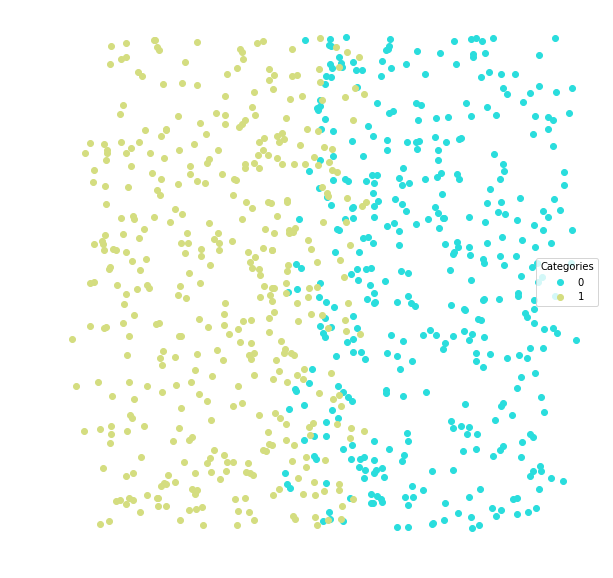

The model used is 0


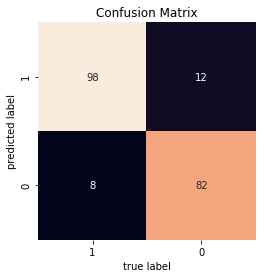

The model used is 0


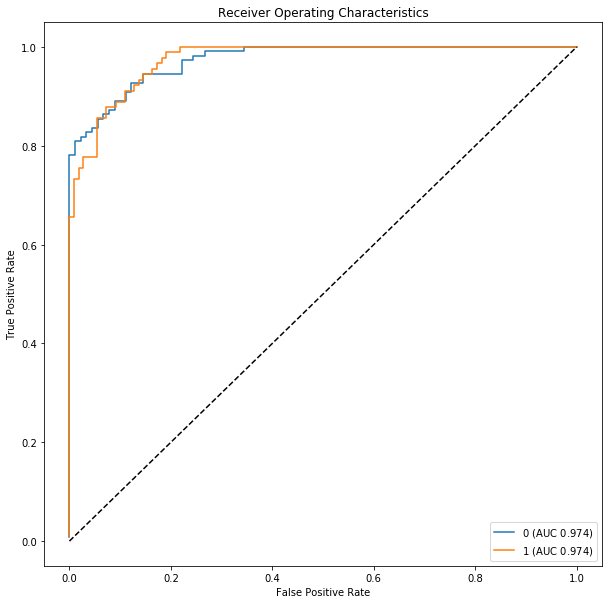

The model used is 0


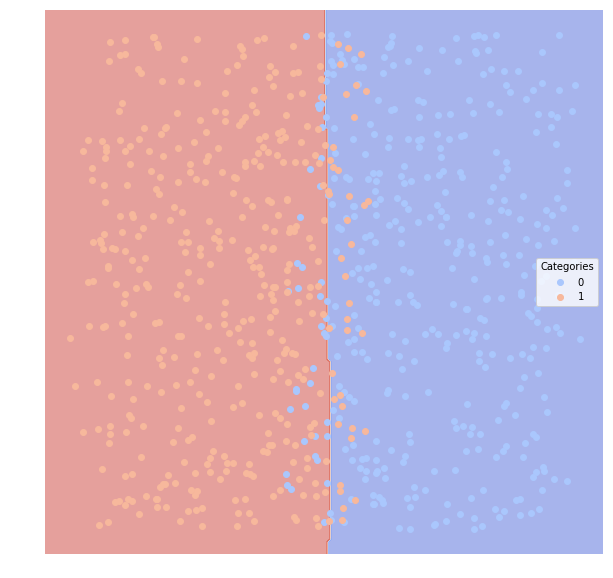

AUC  Average_Precision  Error_Rate  Precision    Recall  Model
Category                                                                    
0         0.90101           0.883671         0.1   0.924528  0.890909  Bayes
1         0.90101           0.834799         0.1   0.872340  0.911111  Bayes

In [273]:
# Classify training and testing
dfTrain, dfTest = artificialData['andSplit02']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Bayes'], True, True, True)

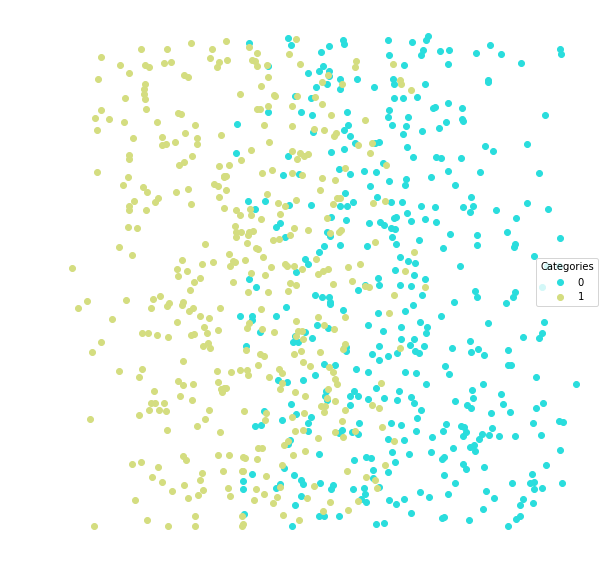

The model used is 3


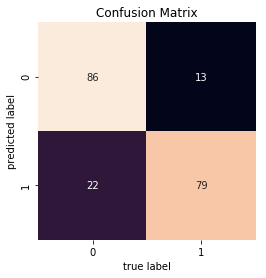

The model used is 3


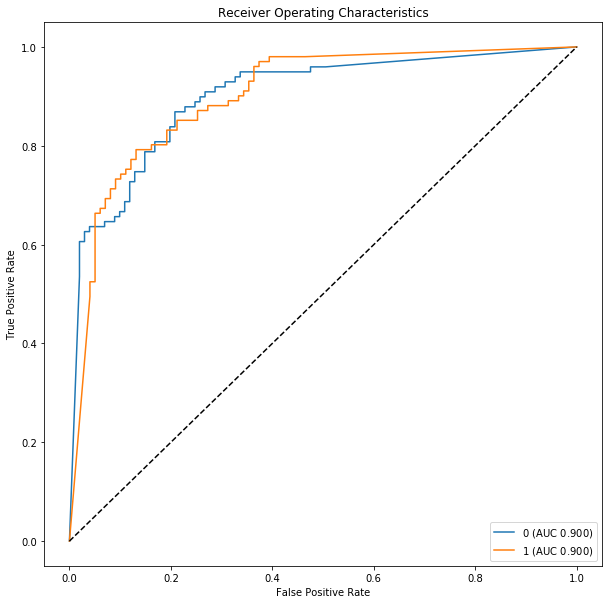

The model used is 3


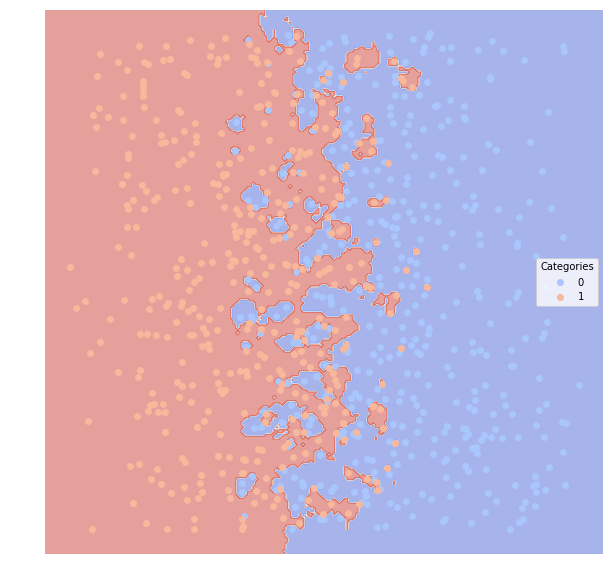

AUC  Average_Precision  Error_Rate  Precision    Recall Model
Category                                                                    
0         0.825433           0.756732       0.175   0.796296  0.868687   KNN
1         0.825433           0.781653       0.175   0.858696  0.782178   KNN

In [274]:
# Classify training and testing
dfTrain, dfTest = artificialData['andSplit04']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['KNN'], True, True, True)

#### In a ascending order by error rate, the superiority of algorithms applying to xorSplit data with noise level to be 0.2 and 0.4 are presented below. We could tell Neural Network Model, Gradient Boosting, KNN, and Random Forest Model works the best for xorSplit data.

In [254]:
masterDF['xorSplit02'].sort_values(by=['Error_Rate']).Model.unique()

array(['Neural Network', 'KNN', 'GradientBoosting', 'RandomForest',
       'Tree', 'SVM_Poly', 'SVM_Linear', 'Bayes', 'Reg'], dtype=object)

In [253]:
masterDF['xorSplit04'].sort_values(by=['Error_Rate']).Model.unique()

array(['GradientBoosting', 'Neural Network', 'RandomForest', 'KNN',
       'Tree', 'SVM_Poly', 'Reg', 'Bayes', 'SVM_Linear'], dtype=object)

So as we could see from the distribution of points below, there is much differences between 0.2 noise and 0.4 noise, which is the amount of confounding points in the middle of plot. With less amount of noise, we could see the blue color points are majorly cluster in the top-left and bottom-right corners of the plot. Because of this easier clustering, neural network model works the best because it could clearly classify the region according to 3 significant clustering by counting the middle intersected part belongs to top-right and bottom-left. 

When noise is high such as at a level of 0.4, we could see the middle intersection part becomes more intricate overlaped by points of both colors. It becomes more complicated in classifying those region, thus Gradient Boosting kicks in and performs the best because because it is a robust out of the box classifier (regressor) that can perform on a dataset on which minimal effort has been spent on cleaning and can learn complex non-linear decision boundaries via boosting.

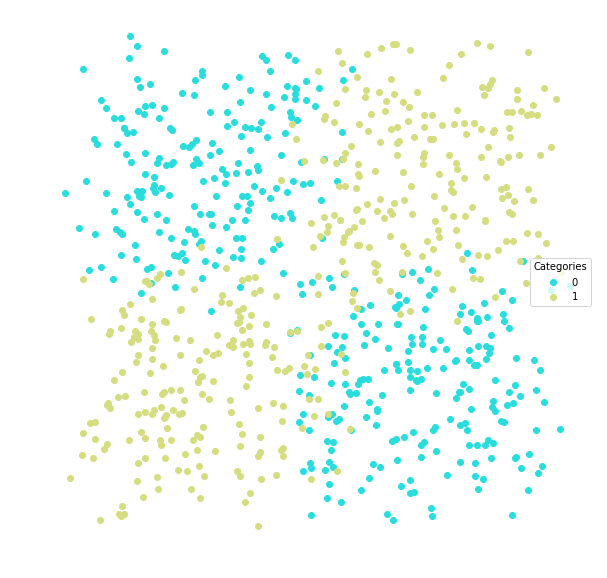

The model used is 7


//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


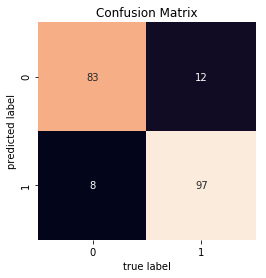

The model used is 7


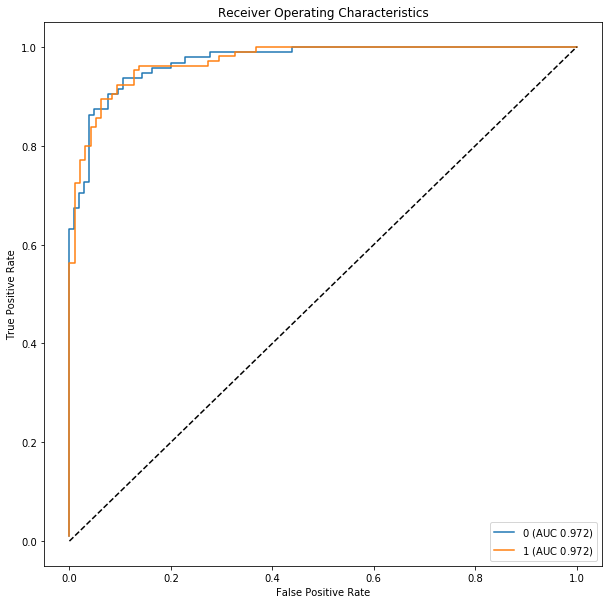

The model used is 7


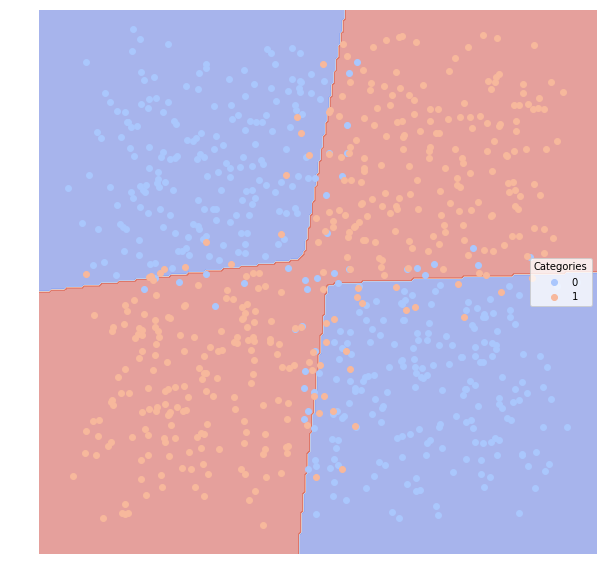

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
0         0.898747           0.856877         0.1   0.912088  0.873684   
1         0.898747           0.862106         0.1   0.889908  0.923810   

                   Model  
Category                  
0         Neural Network  
1         Neural Network

In [275]:
# Classify training and testing
dfTrain, dfTest = artificialData['xorSplit02']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Neural Network'], True, True, True)

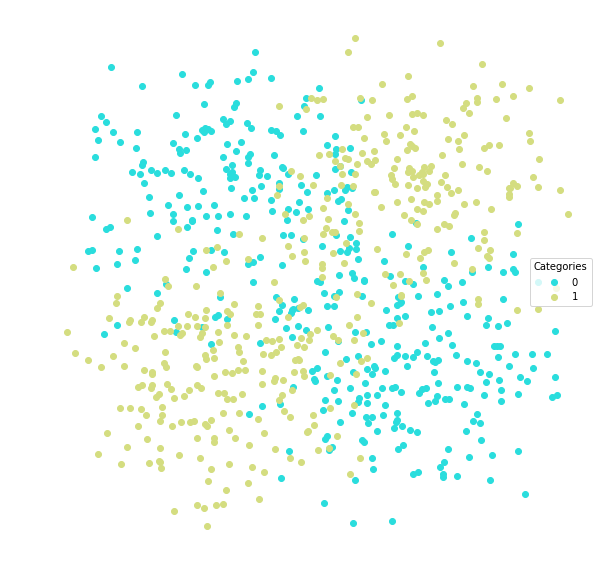

The model used is 8


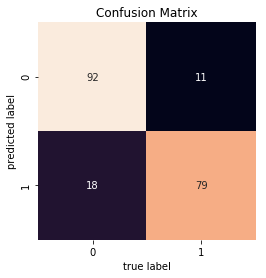

The model used is 8


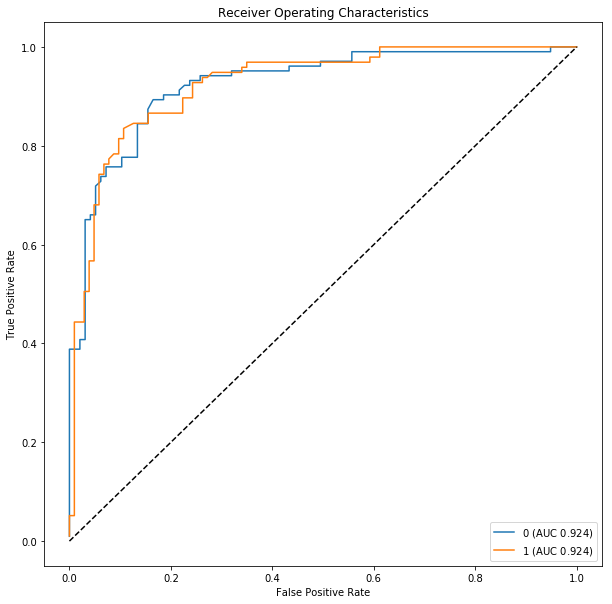

The model used is 8


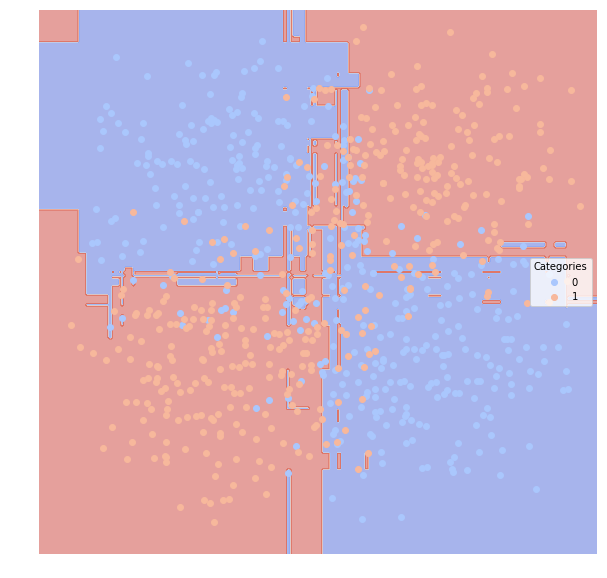

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
0         0.853818           0.802043       0.145   0.836364  0.893204   
1         0.853818           0.804891       0.145   0.877778  0.814433   

                     Model  
Category                    
0         GradientBoosting  
1         GradientBoosting

In [276]:
# Classify training and testing
dfTrain, dfTest = artificialData['xorSplit04']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['GradientBoosting'], True, True, True)

#### In a ascending order by error rate, the superiority of algorithms applying to targetSplit data with noise level to be 0.2 and 0.4 are presented below and from which we could tell Bayes, Gradient Boosting, Neural Network, and RandomForest works the best for targetSplit data.

In [255]:
masterDF['targetSplit02'].sort_values(by=['Error_Rate']).Model.unique()

array(['Bayes', 'GradientBoosting', 'RandomForest', 'Neural Network',
       'KNN', 'Tree', 'SVM_Linear', 'Reg', 'SVM_Poly'], dtype=object)

In [256]:
masterDF['targetSplit04'].sort_values(by=['Error_Rate']).Model.unique()

array(['GradientBoosting', 'Neural Network', 'Bayes', 'RandomForest',
       'KNN', 'Tree', 'SVM_Linear', 'SVM_Poly', 'Reg'], dtype=object)

So as we could see from the distribution of points below, there is much differences between 0.2 noise and 0.4 noise of targetSplit data, which is the amount of confounding points in the middle of plots. With less amount of noise, we could see the blue color points are majorly cluster in the middle with a very clear boundary. Because of this easier clustering, Bayes model works the best because it could clearly classify the region according the circular boundary region. 

When noise is high such as at a level of 0.4, we could see the middle intersection part becomes larger and there are more points fall in the intricate overlaped boundary area. It becomes more complicated to classify those region, thus Gradient Boosting kicks in and performs the best because because it is a robust out of the box classifier (regressor) that can perform on a dataset on which minimal effort has been spent on cleaning and can learn complex non-linear decision boundaries via boosting.

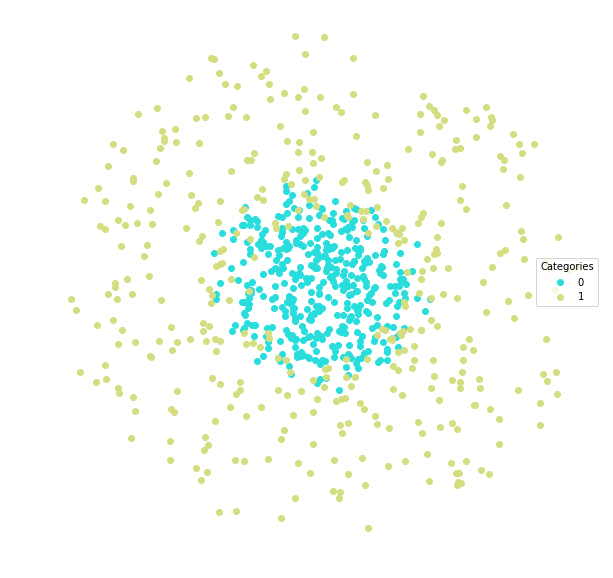

The model used is 0


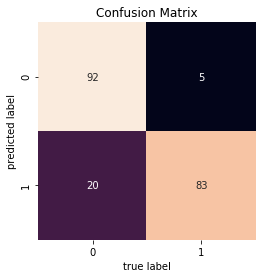

The model used is 0


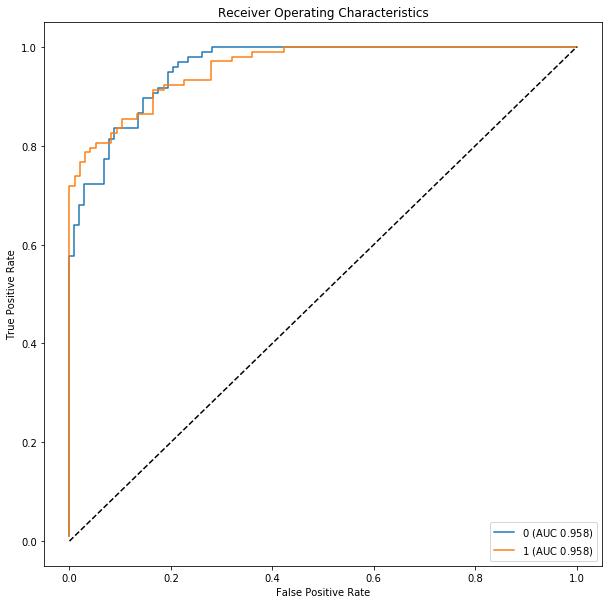

The model used is 0


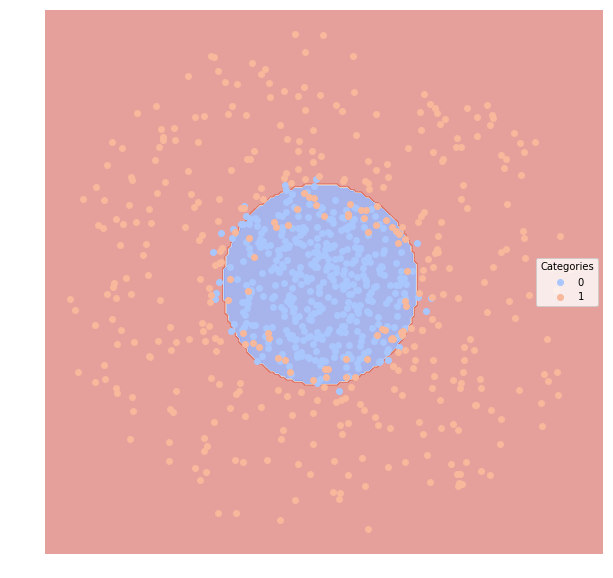

AUC  Average_Precision  Error_Rate  Precision    Recall  Model
Category                                                                     
0         0.877139           0.804087       0.125   0.821429  0.948454  Bayes
1         0.877139           0.860040       0.125   0.943182  0.805825  Bayes

In [277]:
# Classify training and testing
dfTrain, dfTest = artificialData['targetSplit02']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Bayes'], True, True, True)

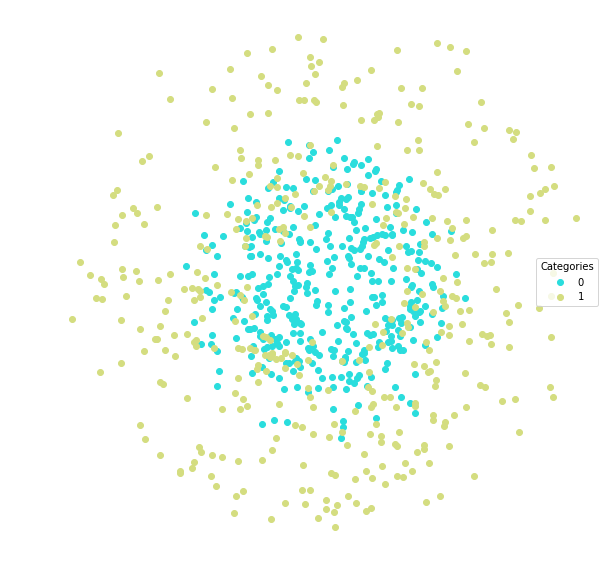

The model used is 8


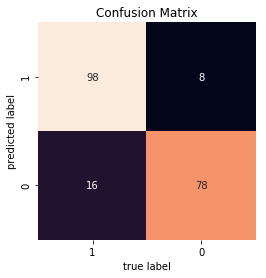

The model used is 8


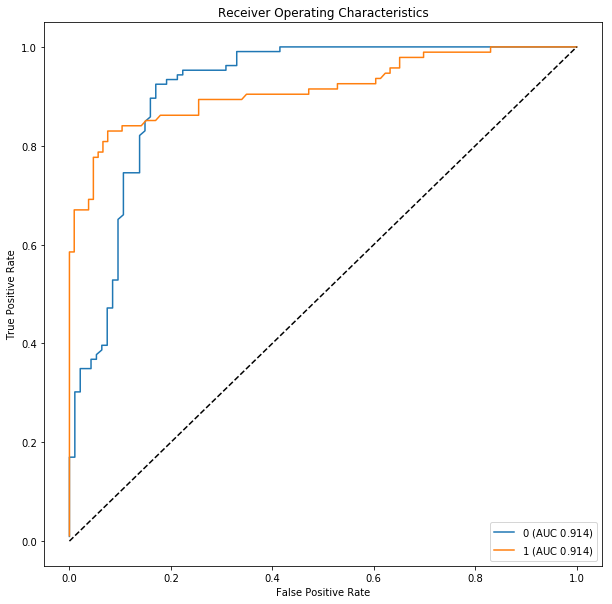

The model used is 8


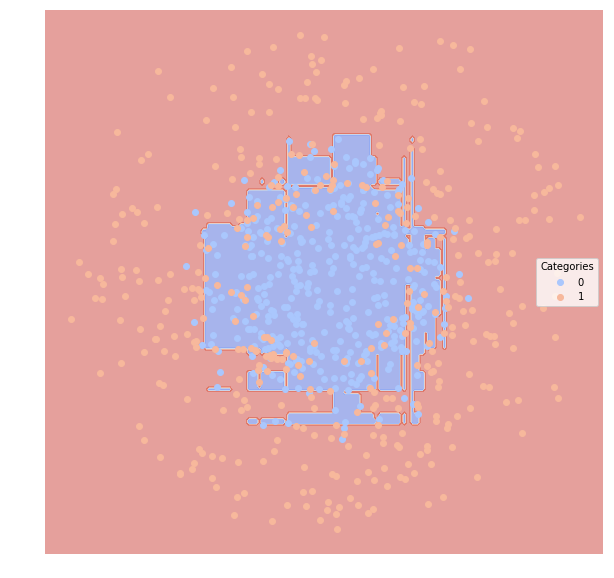

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
0         0.877158           0.834770        0.12   0.859649  0.924528   
1         0.877158           0.832598        0.12   0.906977  0.829787   

                     Model  
Category                    
0         GradientBoosting  
1         GradientBoosting

In [278]:
# Classify training and testing
dfTrain, dfTest = artificialData['targetSplit04']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['GradientBoosting'], True, True, True)

#### In a ascending order by error rate, the superiority of algorithms applying to multiBlobs data with noise level to be 0.2 and 0.4 are presented below, and from which we could know the best method works for this type of blob data are Baynes, SVMs, Gradient Boosting, and KNN models.

In [271]:
masterDF['multiBlobs02'].groupby('Model')['Error_Rate'].mean().sort_values().index

Index(['Bayes', 'SVM_Linear', 'SVM_Poly', 'GradientBoosting', 'KNN',
       'Neural Network', 'RandomForest', 'Tree', 'Reg'],
      dtype='object', name='Model')

In [272]:
masterDF['multiBlobs04'].groupby('Model')['Error_Rate'].mean().sort_values().index

Index(['Bayes', 'SVM_Linear', 'GradientBoosting', 'KNN', 'SVM_Poly',
       'RandomForest', 'Neural Network', 'Tree', 'Reg'],
      dtype='object', name='Model')

Get a sense of overall performances of both dataset, we could tell that the performance overall are great using all methods, but the optimal method for multiBlob data set with 0.2 noise and 0.4 noise is Bayes method.

In [1604]:
subsetDF_Example = masterDF['multiBlobs02'].append(masterDF['multiBlobs04'])
subsetDF_Example[:10]

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
0         1.000000           1.000000       0.000   1.000000  1.000000   
1         1.000000           1.000000       0.000   1.000000  1.000000   
2         0.994845           0.991691       0.002   1.000000  0.989691   
3         0.998698           0.991453       0.002   0.991453  1.000000   
4         1.000000           1.000000       0.000   1.000000  1.000000   
0         1.000000           1.000000       0.000   1.000000  1.000000   
1         1.000000           1.000000       0.000   1.000000  1.000000   
2         0.994845           0.991691       0.002   1.000000  0.989691   
3         0.998698           0.991453       0.002   0.991453  1.000000   
4         1.000000           1.000000       0.000   1.000000  1.000000   

               Model          Data  
Category                            
0              Bayes  multiBlobs02  
1              Bayes  multiBlobs02  
2              Bayes  multiBlobs02  
3              Bayes  multiBlobs02  
4              Bayes  multiBlobs02  
0         SVM_Linear  multiBlobs02  
1         SVM_Linear  multiBlobs02  
2         SVM_Linear  multiBlobs02  
3         SVM_Linear  multiBlobs02  
4         SVM_Linear  multiBlobs02

According to plots below, we could tell the reason of Bayes method to be the best-performing is because it is capable of dividing the plots into very clear-cut regions in a 2 dimensional space, and within each region, there are groups of points of the same color. 

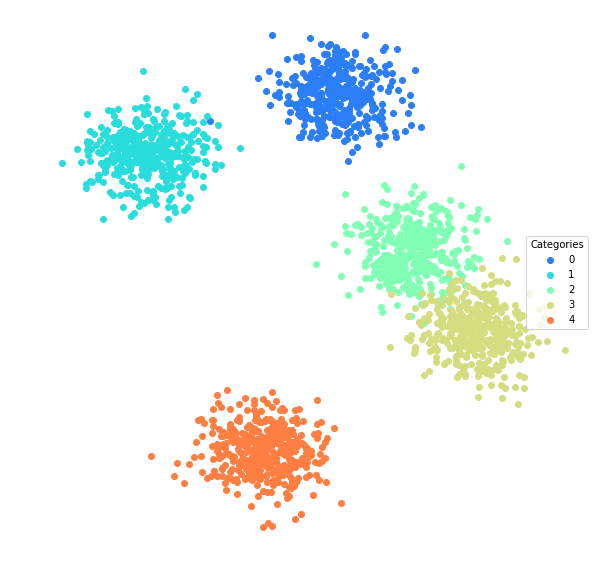

The model used is 0


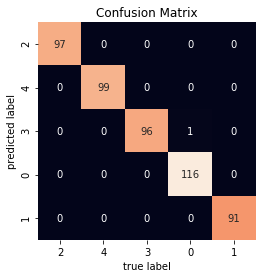

The model used is 0


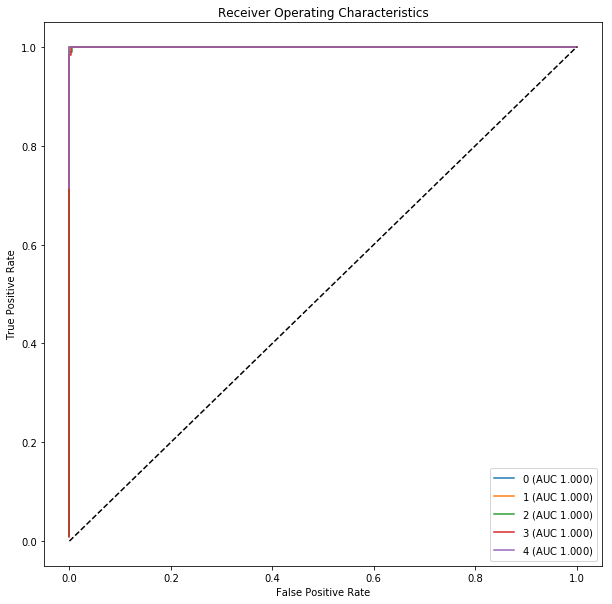

The model used is 0


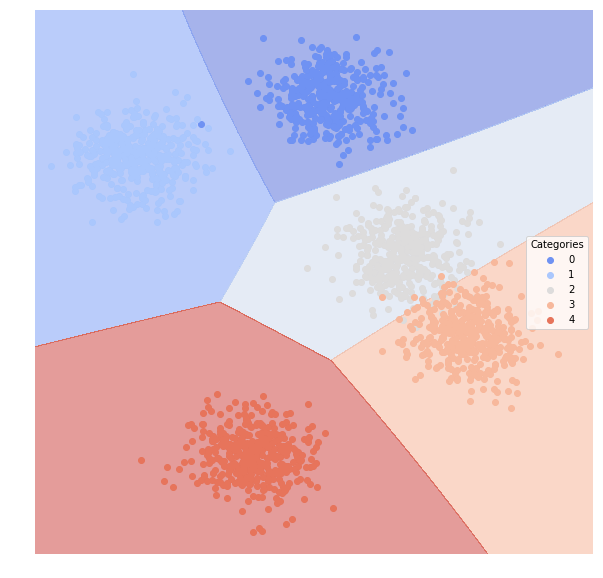

AUC  Average_Precision  Error_Rate  Precision    Recall  Model
Category                                                                     
0         1.000000           1.000000       0.000   1.000000  1.000000  Bayes
1         1.000000           1.000000       0.000   1.000000  1.000000  Bayes
2         0.994845           0.991691       0.002   1.000000  0.989691  Bayes
3         0.998698           0.991453       0.002   0.991453  1.000000  Bayes
4         1.000000           1.000000       0.000   1.000000  1.000000  Bayes

In [279]:
# Classify training and testing
dfTrain, dfTest = artificialData['multiBlobs02']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Bayes'], True, True, True)

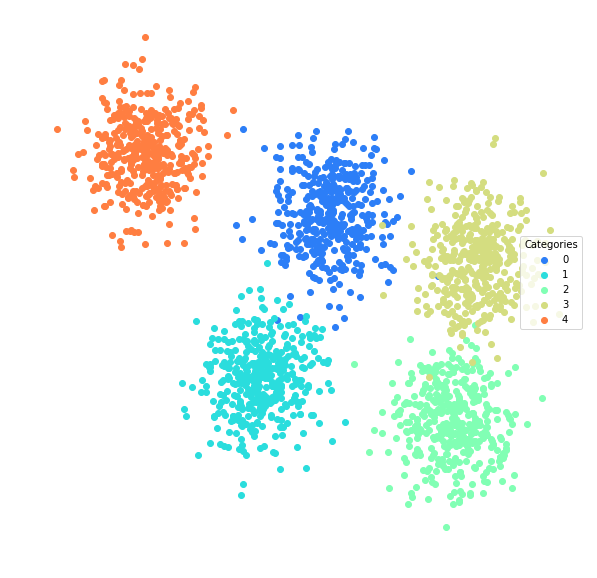

The model used is 0


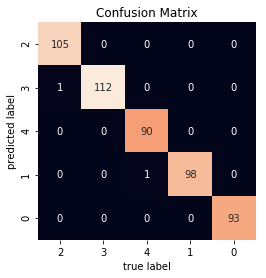

The model used is 0


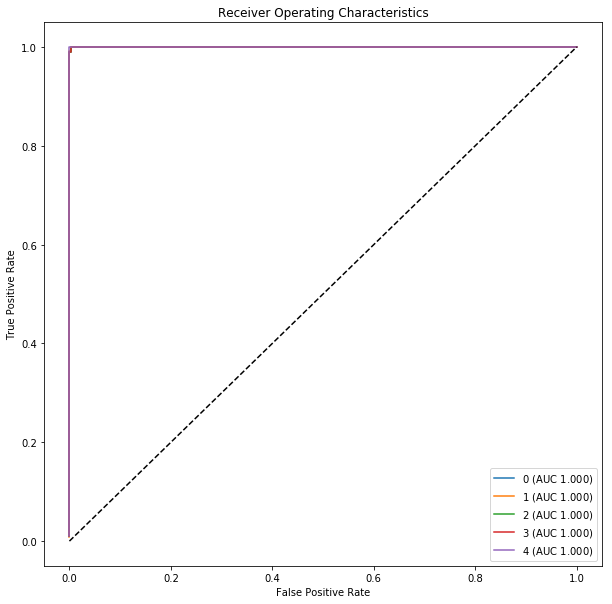

The model used is 0


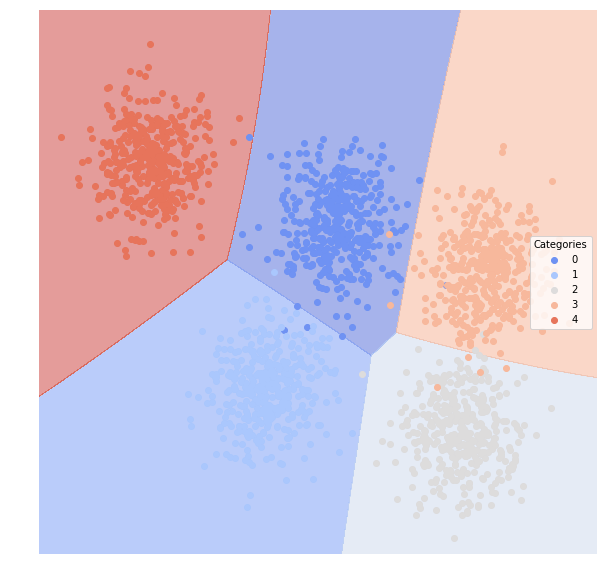

AUC  Average_Precision  Error_Rate  Precision    Recall  Model
Category                                                                     
0         0.998734           0.990566       0.002   0.990566  1.000000  Bayes
1         0.995575           0.993150       0.002   1.000000  0.991150  Bayes
2         0.998780           0.989011       0.002   0.989011  1.000000  Bayes
3         0.994949           0.991899       0.002   1.000000  0.989899  Bayes
4         1.000000           1.000000       0.000   1.000000  1.000000  Bayes

In [281]:
# Classify training and testing
dfTrain, dfTest = artificialData['multiBlobs04']
# Show point distribution
lucem_illud.plotter(dfTrain)
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Bayes'], True, True, True)

Using the artificial data generated by my machine, I could generally summarizes that Bayes methods works the best when there is a clear-cut multi-class data with distinctive boundaries. Gradient Boosting methods is relatively more useful and powerful when the data is subject to influences of high noises. Neural Network model, KNN model, and SVM models are also useful but they work the best when there is less noise in the binary dataset. 

# Go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. 

Obtain real datasets and classify them with all of the available methods. In order to facilitate the process, create a function called ``obtainRealData``. 

In [323]:
def obtainRealData():                                                           
    realDataNames = ['Reddit', 'NewsGroups', 'SenateSmall', 'SenateLarge', 'Spam']      
    finalDict = dict()                                                          
    dfTrain1, dfTest1 = lucem_illud.trainTestSplit(lucem_illud.loadReddit())    
    dfTrain2, dfTest2 = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
    dfTrain3, dfTest3 = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
    dfTrain4, dfTest4 = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
    dfTrain5, dfTest5 = lucem_illud.trainTestSplit(lucem_illud.loadSpam())      
    listTuples = [(dfTrain1, dfTest1),                                          
                  (dfTrain2, dfTest2),                                          
                  (dfTrain3, dfTest3),                                          
                  (dfTrain4, dfTest4),                                          
                  (dfTrain5, dfTest5)]                                          
    for dataName, ttPair in zip(realDataNames, listTuples):                       
        finalDict[dataName] = ttPair                                           
    return finalDict

In [324]:
realData = obtainRealData()

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Kennedy
Loading senator: Kerry
Loading senator: Klobuchar
Loading senator: Kohl
Loading senator: Kyl
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


To run all 9 different machine learning algorithms on each of the data, I will reuse mlCompile function that I created and presented above:

In [326]:
realDF = dict()                                                               
for dataName, ttPair in realData.items():                                
    dfTrain, dfTest = ttPair                                                    
    realDF[dataName] = mlCompile(dfTrain, dfTest, 'all')

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarnin

Construct information for the optimal method:

In [313]:
optimalModelReal = dict()                                                           
# Identify the best machine learning algorithm for each of the artificial data set
for dataName, metricsDF in realDF.items():                                   
    optimalModelReal[dataName] = metricsDF.loc[metricsDF['Error_Rate'] == metricsDF['Error_Rate'].min()]

# Describe which classifier(s) worked best with which each real data:

## Reddit Data

In an ascending order by averaged error rate of each category, the superiority of algorithms applying to Reddit data are presented below, and from which we could know the best method works for Reddit data is Neural Network model.

In [320]:
realDF['Reddit'].groupby(['Model'])['Error_Rate'].mean().sort_values()

Model
Neural Network      0.007837
SVM_Linear          0.009404
Reg                 0.010972
GradientBoosting    0.028213
RandomForest        0.054859
KNN                 0.057994
Tree                0.083072
Bayes               0.142633
SVM_Poly            0.315047
Name: Error_Rate, dtype: float64

According to the confusion matrix, we could tell Neural Network model did an excellent job in classifying these categories. AOC curves are almost close to 1 meaning high accuracy. We could also see the region plot that effect of neural network model in classifying these points in a two dimensional space. It turns out the distribution of the data is very similiar to the pattern called xorSplit showned above, and similiar, this pattern works relatively better using the neural network model presented below.

The model used is 7


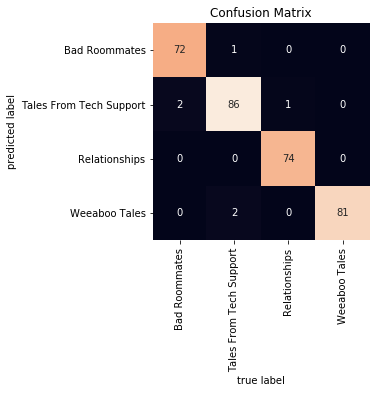

The model used is 7


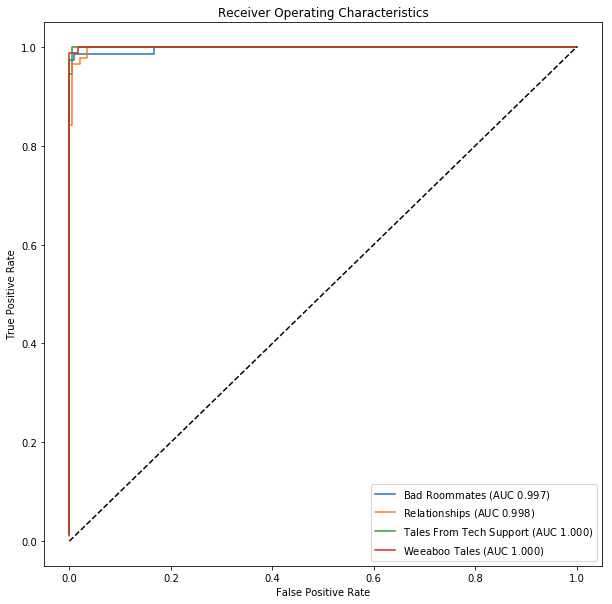

The model used is 7


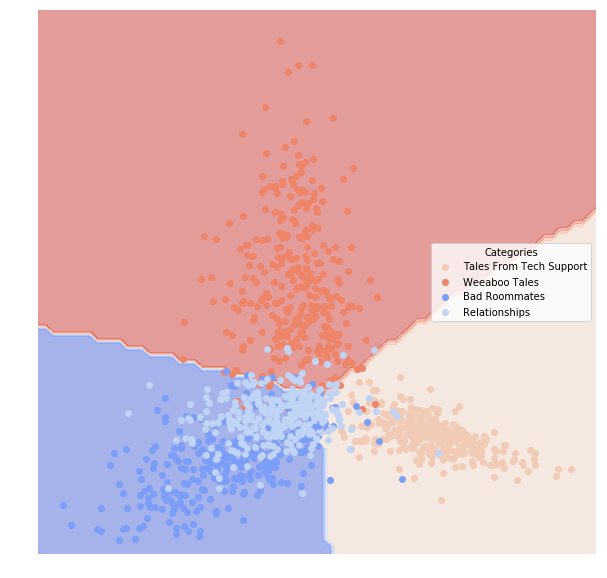

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                      
Relationships            0.976624           0.943125    0.018809   0.966292   
Tales From Tech Support  0.997959           0.986667    0.003135   0.986667   
Weeaboo Tales            0.987952           0.982173    0.006270   1.000000   
Bad Roommates            0.989086           0.962779    0.009404   0.972973   

                           Recall           Model  
Category                                           
Relationships            0.966292  Neural Network  
Tales From Tech Support  1.000000  Neural Network  
Weeaboo Tales            0.975904  Neural Network  
Bad Roommates            0.986301  Neural Network

In [321]:
# Classify training and testing
dfTrain, dfTest = realData['Reddit']
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Neural Network'], True, True, True)

## Newsgroups

In an ascending order by averaged error rate of each category, the superiority of algorithms applying to Newsgroup data are presented below, and from which we could know the best method works for Newsgroups data is Neural Network model and SVM with linear kernal.

In [330]:
realDF['NewsGroups'].groupby(['Model'])['Error_Rate'].mean().sort_values()

Model
Neural Network      0.067021
SVM_Linear          0.067021
Reg                 0.072340
GradientBoosting    0.103191
Bayes               0.110638
RandomForest        0.112766
Tree                0.164894
KNN                 0.340426
SVM_Poly            0.379787
Name: Error_Rate, dtype: float64

According to the confusion matrix, we could tell Neural Network model and SVM model with linear kernal did excellent jobs in classifying these categories. AOC curves are close between 0.96 and 0.98, which implies high accuracy. We could also see the region plot that effect of neural network model in classifying these points in a two dimensional space. It turns out the distribution of the data is very similiar to the pattern called xorSplit showned above, and similiar, this pattern works relatively better using the neural network model and SVM Model with linear kernal presented below.

The model used is 7


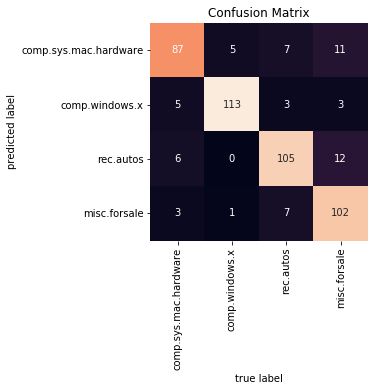

The model used is 7


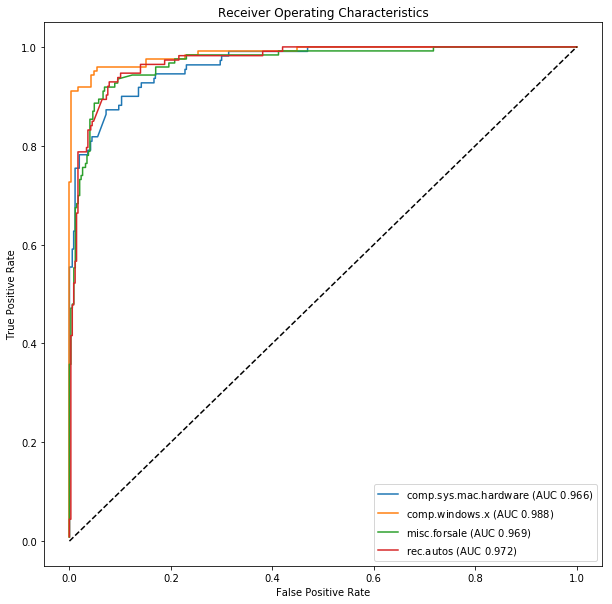

The model used is 7


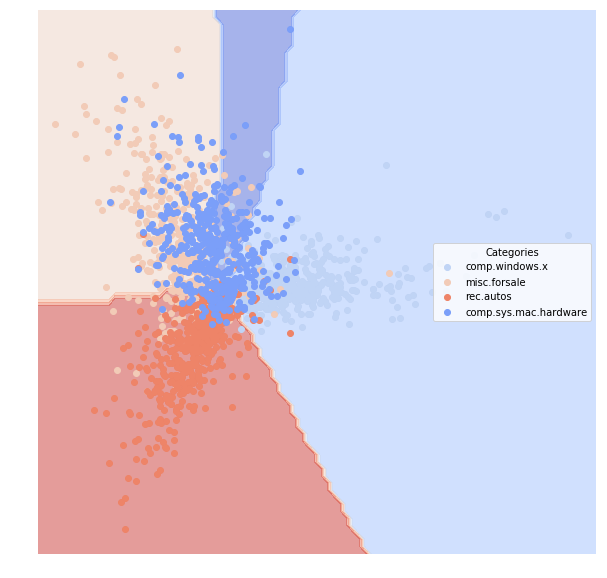

The model used is 1


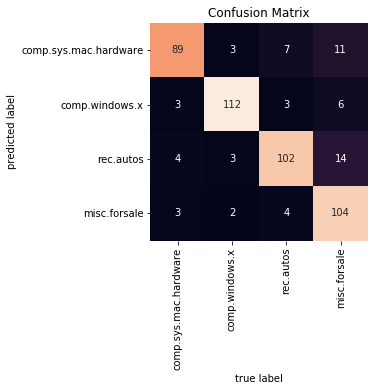

The model used is 1


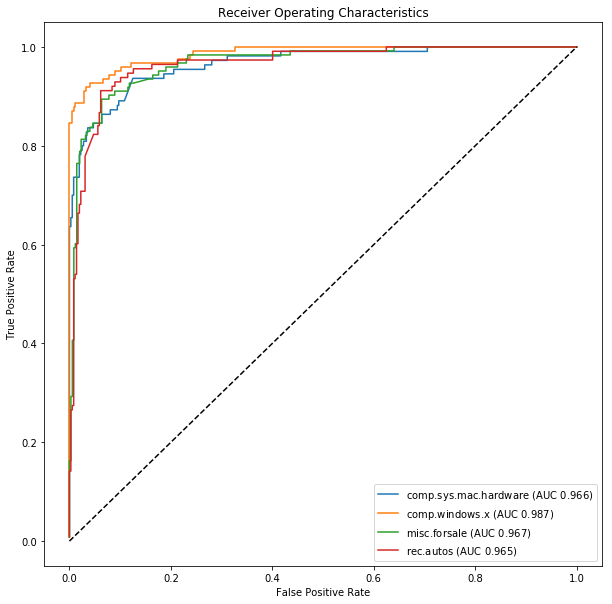

The model used is 1


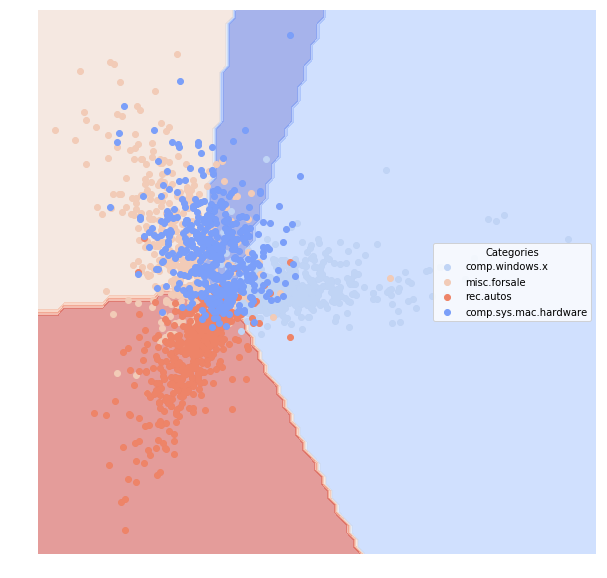

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                    
comp.windows.x         0.946975           0.888747    0.036170   0.949580   
misc.forsale           0.902334           0.773004    0.074468   0.860656   
rec.autos              0.914913           0.742707    0.078723   0.796875   
comp.sys.mac.hardware  0.876010           0.730214    0.078723   0.861386   
comp.windows.x         0.940052           0.868543    0.042553   0.933333   
misc.forsale           0.894461           0.773865    0.074468   0.879310   
rec.autos              0.916760           0.728162    0.085106   0.770370   
comp.sys.mac.hardware  0.890657           0.772045    0.065957   0.898990   

                         Recall           Model  
Category                                         
comp.windows.x         0.911290  Neural Network  
misc.forsale           0.853659  Neural Network  
rec.autos              0.902655  Neural Network  
comp.sys.mac.hardware  0.790909  Neural Network  
comp.windows.x         0.903226      SVM_Linear  
misc.forsale           0.829268      SVM_Linear  
rec.autos              0.920354      SVM_Linear  
comp.sys.mac.hardware  0.809091      SVM_Linear

In [332]:
# Classify training and testing
dfTrain, dfTest = realData['NewsGroups']
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Neural Network', 'SVM_Linear'], True, True, True)

## SenateSmall

In an ascending order by averaged error rate of each category, the superiority of algorithms applying to SenateSmall data are presented below, and from which we could know the best method works for SenateSmall data is Gradient Boosting Model and SVM model with linear kernal.

In [333]:
realDF['SenateSmall'].groupby(['Model'])['Error_Rate'].mean().sort_values()

Model
GradientBoosting    0.008798
SVM_Linear          0.008798
Tree                0.011730
RandomForest        0.014663
Reg                 0.017595
Neural Network      0.038123
KNN                 0.099707
Bayes               0.164223
SVM_Poly            0.410557
Name: Error_Rate, dtype: float64

According to the confusion matrix, we could tell Gradient Boosting method and SVM model with linear kernal did excellent jobs in classifying these categories with only 3 false positives or false negatives. AOC curves are close to 1, which implies high accuracy. We could also see the region plot that effect of neural network model in classifying these points in a two dimensional space. It turns out the distribution of the data is very similiar to the pattern called xorSplit with high noise showned above, and similiarly, we reached the same conclusion as above that this pattern fits relatively better using the neural network model and SVM Model with linear kernal presented below.

The model used is 8


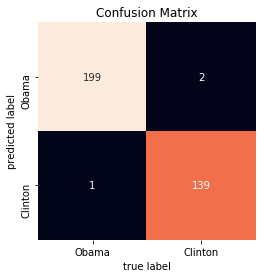

The model used is 8


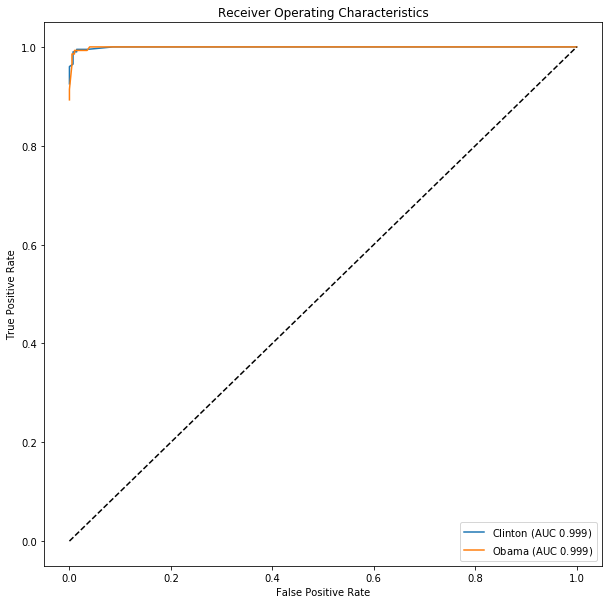

The model used is 8


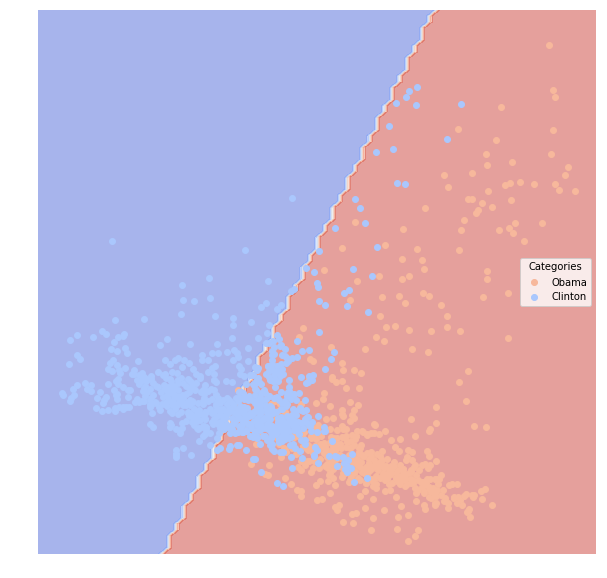

The model used is 1


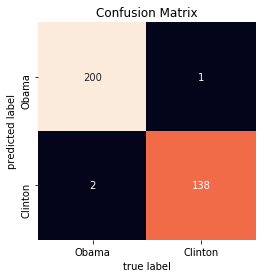

The model used is 1


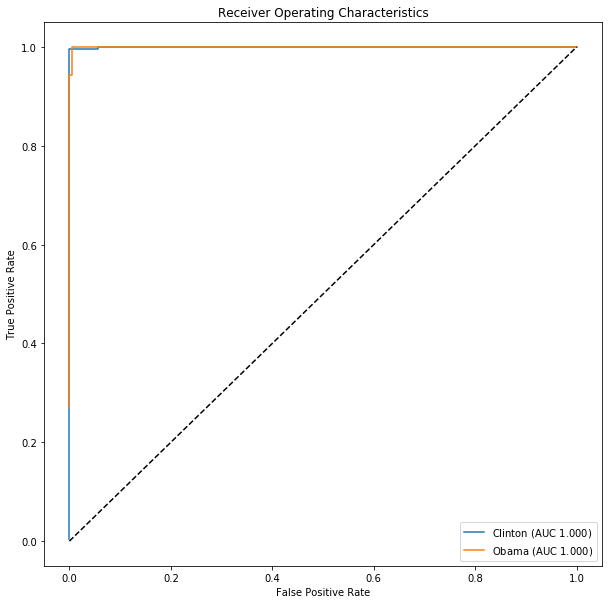

The model used is 1


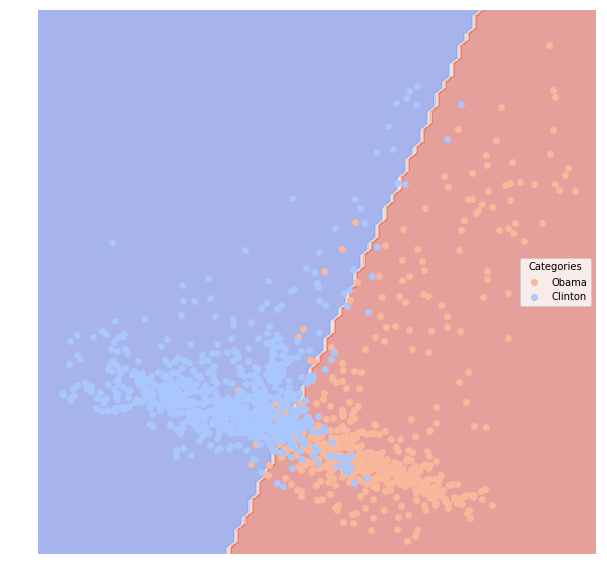

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
Obama     0.991453           0.981707    0.008798   0.985816  0.992857   
Clinton   0.991453           0.990965    0.008798   0.995000  0.990050   
Obama     0.990370           0.984488    0.008798   0.992806  0.985714   
Clinton   0.990370           0.988106    0.008798   0.990099  0.995025   

                     Model  
Category                    
Obama     GradientBoosting  
Clinton   GradientBoosting  
Obama           SVM_Linear  
Clinton         SVM_Linear

In [335]:
# Classify training and testing
dfTrain, dfTest = realData['SenateSmall']
# Show why the optimal
mlCompile(dfTrain, dfTest, ['GradientBoosting', 'SVM_Linear'], True, True, True)

## SenateLarge

In an ascending order by averaged error rate of each category, the superiority of algorithms applying to SenateLarge data are presented below, and from which we could know the best method works for SenateLarge data is Tree model.

In [338]:
realDF['SenateLarge'].groupby(['Model'])['Error_Rate'].mean().sort_values()

Model
Tree                0.001538
GradientBoosting    0.002051
RandomForest        0.010769
SVM_Linear          0.011795
Neural Network      0.021538
Reg                 0.025641
KNN                 0.091282
Bayes               0.111282
SVM_Poly            0.228718
Name: Error_Rate, dtype: float64

According to the confusion matrix, we could tell tree model did excellent jobs in classifying these categories with only 3 points classified wrong. AOC curves are close to 1, which implies high accuracy. We could also see the region plot that effect of neural network model in classifying these points in a two dimensional space. It turns out the distribution of the data is very similiar to the pattern called targetSplit with high noise showned above with multiple classes. However, different from the results above, Tree models seems to fit the best to this this data set. Thus, there seems to be clear cut of classification schemes that could accurately group and cluster data according to certain creterias. In conclusion, tree model fits the best to SenateLarge data set. 

The model used is 5


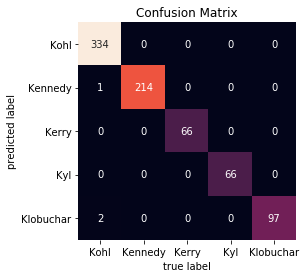

The model used is 5


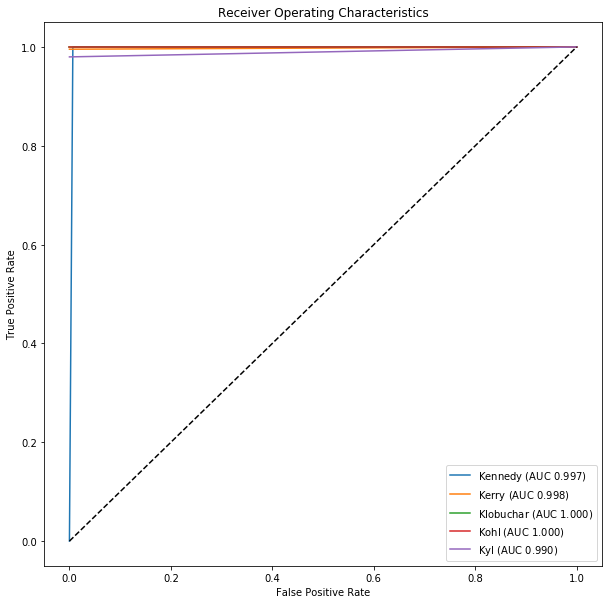

The model used is 5


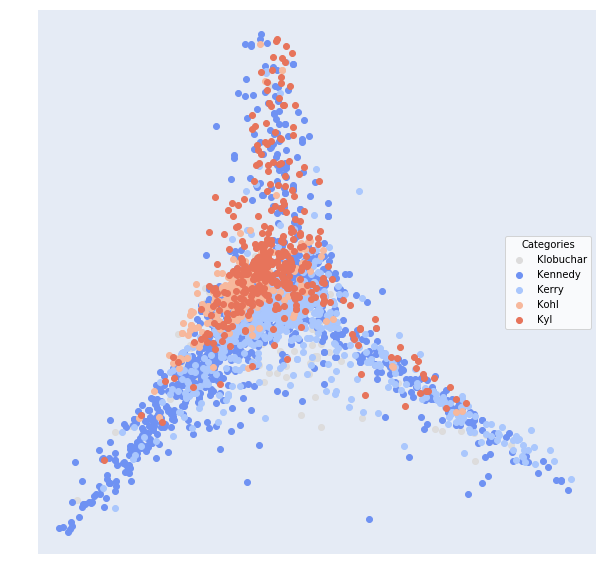

AUC  Average_Precision  Error_Rate  Precision    Recall Model
Category                                                                     
Kerry      0.997674           0.996631    0.001282   1.000000  0.995349  Tree
Kennedy    0.996637           0.991098    0.003846   0.991098  1.000000  Tree
Kohl       1.000000           1.000000    0.000000   1.000000  1.000000  Tree
Klobuchar  1.000000           1.000000    0.000000   1.000000  1.000000  Tree
Kyl        0.989899           0.982362    0.002564   1.000000  0.979798  Tree

In [339]:
# Classify training and testing
dfTrain, dfTest = realData['SenateLarge']
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Tree'], True, True, True)

## Spam

In an ascending order by averaged error rate of each category, the superiority of algorithms applying to Spam data are presented below, and from which we could know the best method works for Reddit data is Random Forest model.

In [336]:
realDF['Spam'].groupby(['Model'])['Error_Rate'].mean().sort_values()

Model
RandomForest        0.090643
SVM_Linear          0.093567
KNN                 0.102339
Neural Network      0.105263
Tree                0.111111
GradientBoosting    0.122807
Reg                 0.124269
SVM_Poly            0.162281
Bayes               0.197368
Name: Error_Rate, dtype: float64

According to the confusion matrix, we could tell Random Forest model did excellent jobs in classifying spam or ham, among which 17 false-positives and 43 false-negatives. AOC curves are close to 1, which implies high accuracy. We could also see the region plot that effect of Random Forest model in classifying these points in a two dimensional space.

The model used is 6


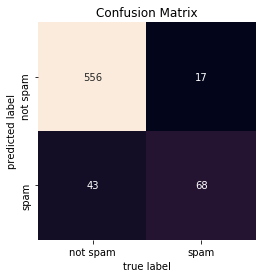

The model used is 6


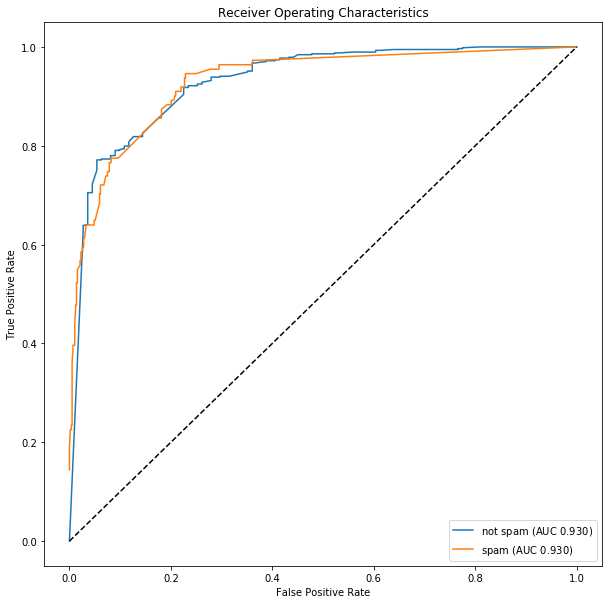

The model used is 6


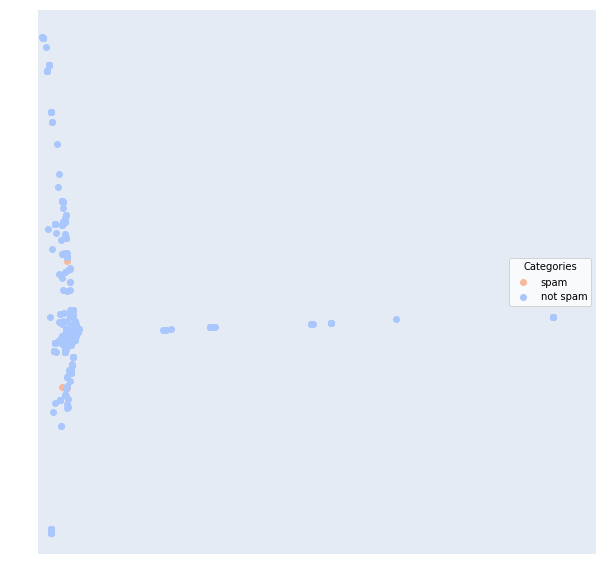

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
spam      0.791472           0.552956    0.087719   0.800000  0.612613   
not spam  0.791472           0.925529    0.087719   0.928214  0.970332   

                 Model  
Category                
spam      RandomForest  
not spam  RandomForest

In [337]:
# Classify training and testing
dfTrain, dfTest = realData['Spam']
# Show why the optimal
mlCompile(dfTrain, dfTest, ['RandomForest'], True, True, True)

# Identify and implement a new classifier 

One artificial dataset I selected to include is xorSplit with noise to be 0.2, and one real dataset is Reddit. To facilitate comparison, a function is created below.

In [342]:
def artificialReal():
    finalDict = dict()
    dataName = ['xorSplit02', 'Reddit']
    dfTrain1, dfTest1 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(0.2))
    dfTrain2, dfTest2 = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
    listTuples = [(dfTrain1, dfTest1),                                          
                  (dfTrain2, dfTest2)]
    for splitName, ttPair in zip(dataName, listTuples):                       
        finalDict[splitName] = ttPair                                           
    return finalDict    

In [343]:
comboData = artificialReal()

Loading Reddit data
Converting to vectors


Create a function that will apply training and testing data using algorithm called Adaboost:

In [352]:
def adaboost(dfTrain, dfTest, confusion = False, roc = False, regionPlot = False):
    ##### Training machine learning algorithms                                  
    modelName = 'AdaBoost'
    adaboost_clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)      
    ##### Fitting the model given training data                                 
    training = adaboost_clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    testing = lucem_illud.evaluateClassifier(training, dfTest)
    testing['Model'] = modelName
                                                                                            
    ##### Plotting 
    print('The model used is {}'.format(modelName))                     
    if confusion:
        lucem_illud.plotConfusionMatrix(training, dfTest)                   
    if roc:                                                                 
        lucem_illud.plotMultiROC(training, dfTest)                          
    if regionPlot:                                                          
        lucem_illud.plotregions(training, dfTrain)                          
    return testing

To assess performance, run AdaBoost on the two selected data

In [353]:
adaDF = dict()                                                               
for dataName, ttPair in comboData.items():                                
    dfTrain, dfTest = ttPair                                                    
    adaDF[dataName] = adaboost(dfTrain, dfTest)

The model used is AdaBoost
The model used is AdaBoost


## Assessment on artificial data set:

In [355]:
adaDF['xorSplit02']

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
0         0.524758           0.472964       0.475   0.484848  0.521739   
1         0.524758           0.552855       0.475   0.564356  0.527778   

             Model  
Category            
0         AdaBoost  
1         AdaBoost

Recall the optimal machine learning algorithm applying to xorSplit02 type of distribution is neural network model with an error-rate of 0.1. The performance of AdaBoost is inferoior than Neural Network model in this case. 

In [356]:
# Classify training and testing
dfTrain, dfTest = artificialData['xorSplit02']
# Show why the optimal
mlCompile(dfTrain, dfTest, ['Neural Network'])

//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
0         0.898747           0.856877         0.1   0.912088  0.873684   
1         0.898747           0.862106         0.1   0.889908  0.923810   

                   Model  
Category                  
0         Neural Network  
1         Neural Network

### Assess AdaBoose:

The error rate is approximately 0.5, which is almost like guessing in this binary dataset. Thus, we could claim AdaBoost does not work well and should not be applied to clusters such as xorSplit.

The model used is AdaBoost


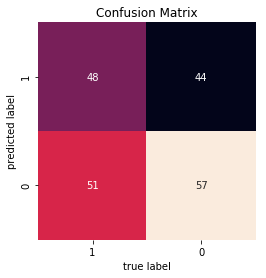

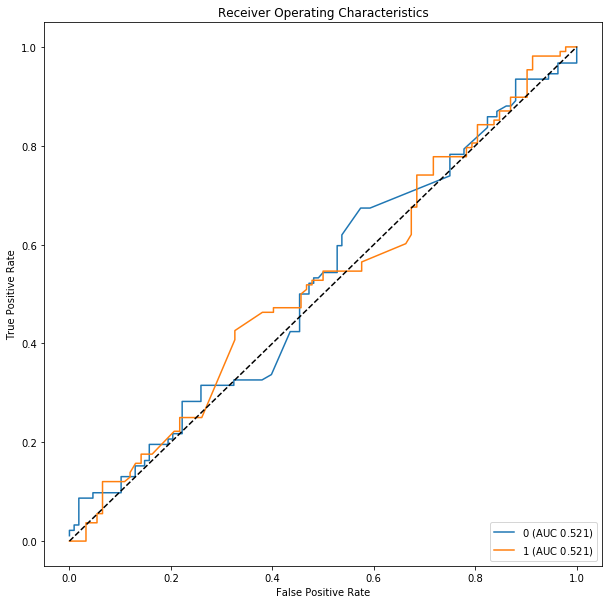

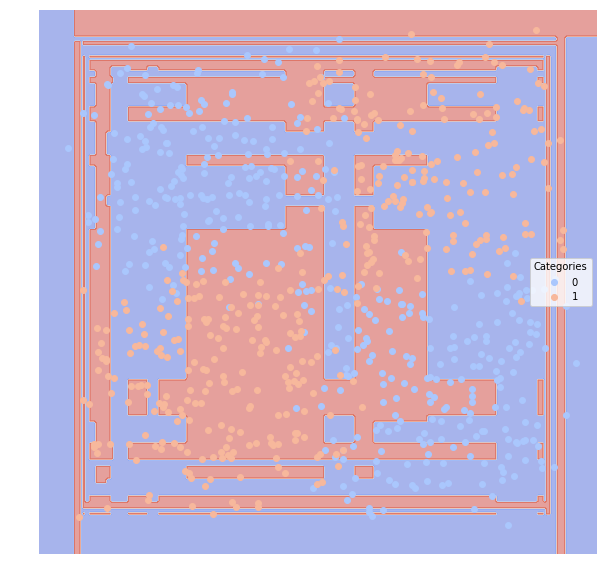

AUC  Average_Precision  Error_Rate  Precision    Recall  \
Category                                                                 
0         0.524758           0.472964       0.475   0.484848  0.521739   
1         0.524758           0.552855       0.475   0.564356  0.527778   

             Model  
Category            
0         AdaBoost  
1         AdaBoost

In [364]:
# Classify training and testing
dfTrain, dfTest = comboData['xorSplit02']
# Show why the optimal
adaboost(dfTrain, dfTest, True, True, True)

## Assessment on Reddit data set

In [354]:
adaDF['Reddit']

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                      
Tales From Tech Support  0.880241           0.741660    0.087774   0.851852   
Weeaboo Tales            0.922610           0.867563    0.043887   0.972222   
Bad Roommates            0.788841           0.553929    0.125392   0.745763   
Relationships            0.818869           0.555618    0.175549   0.626168   

                           Recall     Model  
Category                                     
Tales From Tech Support  0.811765  AdaBoost  
Weeaboo Tales            0.853659  AdaBoost  
Bad Roommates            0.637681  AdaBoost  
Relationships            0.807229  AdaBoost

Compute the average of the error rate:

In [363]:
adaDF['Reddit']['Error_Rate'].mean()

0.10815047021943575

Recall the optimal machine learning algorithms fits the best out of 9 models is the Neural Network Model indicated above.

In [360]:
# Classify training and testing
dfTrain, dfTest = realData['Reddit']
# Show why the optimal
Reddit_nn = mlCompile(dfTrain, dfTest, ['Neural Network'])
Reddit_nn

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                      
Relationships            0.960489           0.904034    0.031348   0.942529   
Tales From Tech Support  1.000000           1.000000    0.000000   1.000000   
Weeaboo Tales            0.988841           0.961082    0.009404   0.971831   
Bad Roommates            0.962041           0.912033    0.028213   0.952381   

                           Recall           Model  
Category                                           
Relationships            0.942529  Neural Network  
Tales From Tech Support  1.000000  Neural Network  
Weeaboo Tales            0.985714  Neural Network  
Bad Roommates            0.941176  Neural Network

Compute the average of the error rate:

In [362]:
Reddit_nn['Error_Rate'].mean()

0.017241379310344862

In conclusion, it seems that AdaBoost does not work well for my selected artificial data, but it would fairly well for the Reddit data.

### Assess AdaBoose:

According to the confusion matrix, the rate of accuracy is fairly well. Adaboost works really well categorizing three categories, and they are "Bad Roommates", "Tales from Tech Support", and "Weeboo Tales" as the AOC is between 0.94 and 0.98. However, AdaBoost does not do well in identifying "Relationships" as the AOC is only 0.76. The region plot shows the classification, which is intuitive and similiar to the nueral network region plot presented above.

The model used is AdaBoost


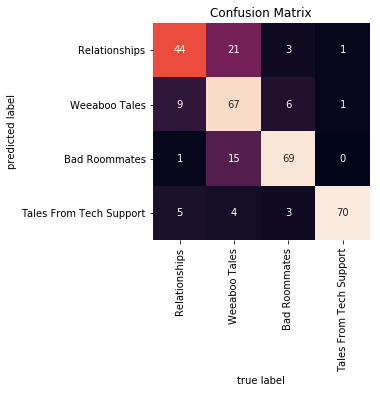

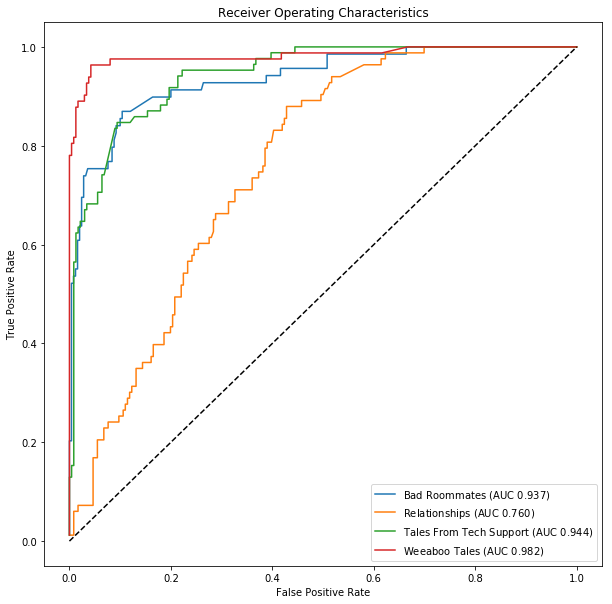

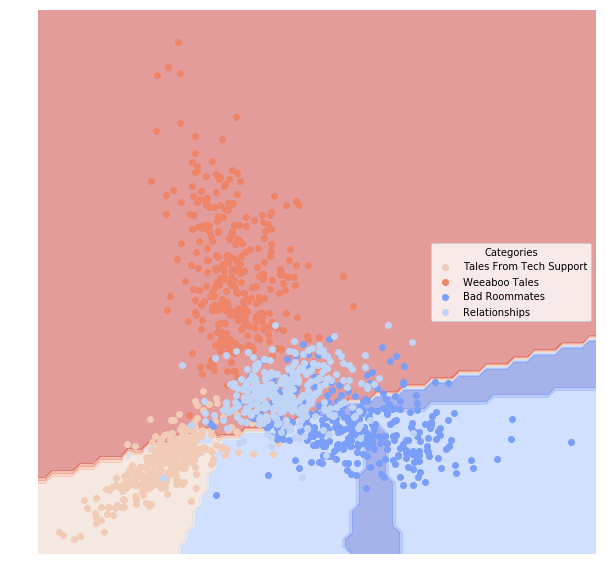

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                      
Tales From Tech Support  0.880241           0.741660    0.087774   0.851852   
Weeaboo Tales            0.922610           0.867563    0.043887   0.972222   
Bad Roommates            0.788841           0.553929    0.125392   0.745763   
Relationships            0.818869           0.555618    0.175549   0.626168   

                           Recall     Model  
Category                                     
Tales From Tech Support  0.811765  AdaBoost  
Weeaboo Tales            0.853659  AdaBoost  
Bad Roommates            0.637681  AdaBoost  
Relationships            0.807229  AdaBoost

In [365]:
# Classify training and testing
dfTrain, dfTest = comboData['Reddit']
# Show why the optimal
adaboost(dfTrain, dfTest, True, True, True)

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [30]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

In [417]:
ObamaClintonReleases.tail(10)

download_url  \
1699  https://raw.githubusercontent.com/lintool/Grim...   
1700  https://raw.githubusercontent.com/lintool/Grim...   
1701  https://raw.githubusercontent.com/lintool/Grim...   
1702  https://raw.githubusercontent.com/lintool/Grim...   
1703  https://raw.githubusercontent.com/lintool/Grim...   
1704  https://raw.githubusercontent.com/lintool/Grim...   
1705  https://raw.githubusercontent.com/lintool/Grim...   
1706  https://raw.githubusercontent.com/lintool/Grim...   
1707  https://raw.githubusercontent.com/lintool/Grim...   
1708  https://raw.githubusercontent.com/lintool/Grim...   

                                               html_url  \
1699  https://github.com/lintool/GrimmerSenatePressR...   
1700  https://github.com/lintool/GrimmerSenatePressR...   
1701  https://github.com/lintool/GrimmerSenatePressR...   
1702  https://github.com/lintool/GrimmerSenatePressR...   
1703  https://github.com/lintool/GrimmerSenatePressR...   
1704  https://github.com/lintool/GrimmerSenatePressR...   
1705  https://github.com/lintool/GrimmerSenatePressR...   
1706  https://github.com/lintool/GrimmerSenatePressR...   
1707  https://github.com/lintool/GrimmerSenatePressR...   
1708  https://github.com/lintool/GrimmerSenatePressR...   

                        name                                path  \
1699  1Oct2006Clinton121.txt  raw/Clinton/1Oct2006Clinton121.txt   
1700  1Oct2007Clinton289.txt  raw/Clinton/1Oct2007Clinton289.txt   
1701  1Oct2007Clinton290.txt  raw/Clinton/1Oct2007Clinton290.txt   
1702  1Sep2005Clinton283.txt  raw/Clinton/1Sep2005Clinton283.txt   
1703  1Sep2005Clinton284.txt  raw/Clinton/1Sep2005Clinton284.txt   
1704  1Sep2005Clinton285.txt  raw/Clinton/1Sep2005Clinton285.txt   
1705  1Sep2005Clinton286.txt  raw/Clinton/1Sep2005Clinton286.txt   
1706  1Sep2005Clinton287.txt  raw/Clinton/1Sep2005Clinton287.txt   
1707  1Sep2006Clinton207.txt  raw/Clinton/1Sep2006Clinton207.txt   
1708  1Sep2006Clinton208.txt  raw/Clinton/1Sep2006Clinton208.txt   

                                                   text targetSenator  \
1699  October 1  2006 Senator Clinton and Former Buf...       Clinton   
1700  October 1  2007 Senator Clinton Welcomes Senat...       Clinton   
1701  October 1  2007 Senator Clinton Announces Co S...       Clinton   
1702  September 1  2005 Senator Clinton Picks Offici...       Clinton   
1703  September 1  2005 Senator Clinton and Foodlink...       Clinton   
1704  September 1  2005 Senator Clinton Visit Infoto...       Clinton   
1705  September 1  2005 Senator Clinton Announces Ex...       Clinton   
1706  September 1  2005 Senator Clinton Joins Local ...       Clinton   
1707  September 1  2006 Clintons Meet with Cazenovia...       Clinton   
1708  September 1  2006 Al Qaeda Publishes Online  D...       Clinton   

      category                                     tokenized_text  \
1699     False  [October, 1, 2006, Senator, Clinton, and, Form...   
1700     False  [October, 1, 2007, Senator, Clinton, Welcomes,...   
1701     False  [October, 1, 2007, Senator, Clinton, Announces...   
1702     False  [September, 1, 2005, Senator, Clinton, Picks, ...   
1703     False  [September, 1, 2005, Senator, Clinton, and, Fo...   
1704     False  [September, 1, 2005, Senator, Clinton, Visit, ...   
1705     False  [September, 1, 2005, Senator, Clinton, Announc...   
1706     False  [September, 1, 2005, Senator, Clinton, Joins, ...   
1707     False  [September, 1, 2006, Clintons, Meet, with, Caz...   
1708     False  [September, 1, 2006, Al, Qaeda, Publishes, Onl...   

                                        normalized_text  
1699  [octob, senat, clinton, former, buffalo, bill,...  
1700  [octob, senat, clinton, welcom, senat, approv,...  
1701  [octob, senat, clinton, announc, co, sponsorsh...  
1702  [septemb, senat, clinton, pick, offici, first,...  
1703  [septemb, senat, clinton, foodlink, partner, h...  
1704  [septemb, senat, clinton, visit, infoton, tech...  
1705  [septemb, senat, c

Let's turn the 'targetSenator' column into a binary category variable.

In [369]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

In [371]:
ObamaClintonReleases.loc[:10]

download_url  \
0   https://raw.githubusercontent.com/lintool/Grim...   
1   https://raw.githubusercontent.com/lintool/Grim...   
2   https://raw.githubusercontent.com/lintool/Grim...   
3   https://raw.githubusercontent.com/lintool/Grim...   
4   https://raw.githubusercontent.com/lintool/Grim...   
5   https://raw.githubusercontent.com/lintool/Grim...   
6   https://raw.githubusercontent.com/lintool/Grim...   
7   https://raw.githubusercontent.com/lintool/Grim...   
8   https://raw.githubusercontent.com/lintool/Grim...   
9   https://raw.githubusercontent.com/lintool/Grim...   
10  https://raw.githubusercontent.com/lintool/Grim...   

                                             html_url                   name  \
0   https://github.com/lintool/GrimmerSenatePressR...  10Apr2007Obama430.txt   
1   https://github.com/lintool/GrimmerSenatePressR...  10Apr2008Obama108.txt   
2   https://github.com/lintool/GrimmerSenatePressR...  10Aug2005Obama674.txt   
3   https://github.com/lintool/GrimmerSenatePressR...  10Aug2005Obama675.txt   
4   https://github.com/lintool/GrimmerSenatePressR...  10Aug2006Obama508.txt   
5   https://github.com/lintool/GrimmerSenatePressR...  10Dec2007Obama192.txt   
6   https://github.com/lintool/GrimmerSenatePressR...  10Jan2007Obama472.txt   
7   https://github.com/lintool/GrimmerSenatePressR...  10Jan2008Obama165.txt   
8   https://github.com/lintool/GrimmerSenatePressR...   10Jul2008Obama28.txt   
9   https://github.com/lintool/GrimmerSenatePressR...   10Jul2008Obama29.txt   
10  https://github.com/lintool/GrimmerSenatePressR...   10Jun2008Obama63.txt   

                               path  \
0   raw/Obama/10Apr2007Obama430.txt   
1   raw/Obama/10Apr2008Obama108.txt   
2   raw/Obama/10Aug2005Obama674.txt   
3   raw/Obama/10Aug2005Obama675.txt   
4   raw/Obama/10Aug2006Obama508.txt   
5   raw/Obama/10Dec2007Obama192.txt   
6   raw/Obama/10Jan2007Obama472.txt   
7   raw/Obama/10Jan2008Obama165.txt   
8    raw/Obama/10Jul2008Obama28.txt   
9    raw/Obama/10Jul2008Obama29.txt   
10   raw/Obama/10Jun2008Obama63.txt   

                                                 text targetSenator  category  \
0      Obama Calls on IRS to Protect Taxpayers    ...         Obama      True   
1      Statement from Senator Barack Obama on the ...         Obama      True   
2      Obama Says Bill Will Help Cut Off Supply of...         Obama      True   
3      Obama  Durbin Say Illinois Will Receive 33 ...         Obama      True   
4      Obama Introduces Bill to Help Tap Power of ...         Obama      True   
5      Statement of Senator Barack Obama on Intern...         Obama      True   
6      Legislation to Increase Availability and Us...         Obama      True   
7      Obama Statement on the Flooding in East Cen...         Obama      True   
8      Obama  Green Applaud House Passage of Bill ...         Obama      True   
9      Obama Joins Schumer and McCaskill to Call o...         Obama      True   
10     Statement of Senator Barack Obama on Senate...         Obama      True   

                                       tokenized_text  \
0   [Obama, Calls, on, IRS, to, Protect, Taxpayers...   
1   [Statement, from, Senator, Barack, Obama, on, ...   
2   [Obama, Says, Bill, Will, Help, Cut, Off, Supp...   
3   [Obama, Durbin, Say, Illinois, Will, Receive, ...   
4   [Obama, Introduces, Bill, to, Help, Tap, Power...   
5   [Statement, of, Senator, Barack, Obama, on, In...   
6   [Legislation, to, Increase, Availability, and,...   
7   [Obama, Statement, on, the, Flooding, in, East...   
8   [Obama, Green, Applaud, House, Passage, of, Bi...   
9   [Obama, Joins, Schumer, and, McCaskill, to, Ca...   
10  [Statement, of, Senator, Barack, Obama, on, Se...   

                                      normalized_text  
0   [obama, call, ir, protect, taxpay, privaci, u,...  
1   [statement, senat, barack, obama, dodd, shelbi...  
2   [obama, say, bill, help, cut, suppli, danger, ...  
3   [obama, durbin, say, illinoi, receiv, pe

Tokenize and normalize

In [372]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleasehos['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Let's split the data into training data and testing data.

In [426]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [427]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [428]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [429]:
TFVects.shape

(1368, 11264)

We can save this in the dataframe to make things easier

In [430]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [431]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [432]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

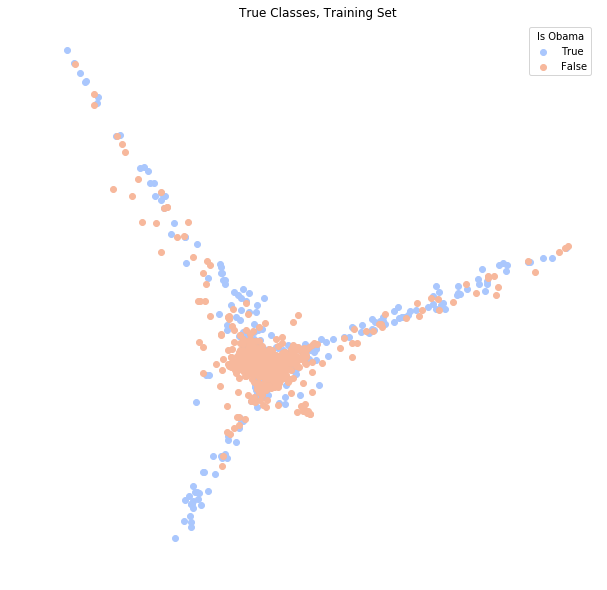

In [433]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

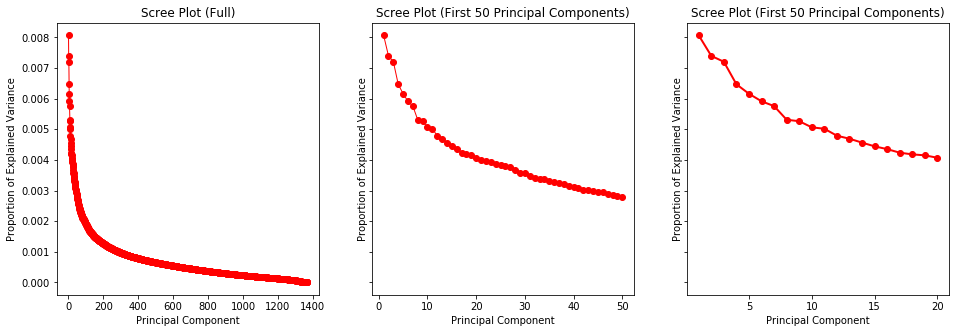

In [381]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [382]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [383]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [384]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6732456140350878

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [385]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6392961876832844

Slightly poorer. How about using more dimensions (40)?

In [386]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7258771929824561
Testing:
0.7008797653958945


Or still more (100)?

In [387]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.810672514619883
Testing:
0.7448680351906158


Or even more (200)!

In [388]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8728070175438597
Testing:
0.8035190615835777


This is becoming ridiculous (400)!

In [389]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9173976608187134
Testing:
0.8211143695014663


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [390]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8355263157894737


Train the model using training data, and then test it on the testing data.

In [391]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8005865102639296


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [392]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [393]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9590643274853801
Testing:
0.8885630498533724


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [394]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [395]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.8441558441558441

Recall:

In [396]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.9027777777777778

F1-measure:

In [397]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.87248322147651

Let's take a look at how well our posterior distribution looks relative to the truth.

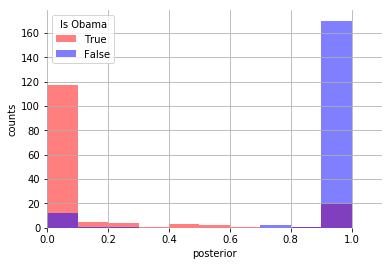

In [398]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [399]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

Clinton  Clinton_log_prob         Obama  Obama_log_prob
0        5566         -1.789966      welcomed       -2.260537
1        dick         -1.800777        island       -2.272371
2      monday         -1.811706  announcement       -2.333740
3         amy         -1.845228        ground       -2.372455
4    brundage         -1.928116         urban       -2.399123
5     chicago         -1.965856  construction       -2.440508
6      reform         -2.179431        having       -2.440508
7     respond         -2.245028          read       -2.440508
8   temporary         -2.279514    supporting       -2.454693
9    reported         -2.297214       welcome       -2.454693
10         va         -2.297214         urged       -2.469082
11      cases         -2.315232         bills       -2.483680
12  oversight         -2.315232         class       -2.483680
13   location         -2.333581       created       -2.498495
14  political         -2.333581       follows       -2.513533

## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [400]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [401]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [402]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: nltk.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [403]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [404]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [405]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [406]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [407]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.9007544979686594


In [408]:
train_ng_df[['category', 'nb_predict']][:10]

category              nb_predict
1413               sci.space               sci.space
1878           comp.graphics           comp.graphics
1675           comp.graphics           comp.graphics
661   soc.religion.christian  soc.religion.christian
112       talk.religion.misc      talk.religion.misc
580   soc.religion.christian  soc.religion.christian
1519               sci.space               sci.space
804   soc.religion.christian  soc.religion.christian
2051           comp.graphics           comp.graphics
972   soc.religion.christian  soc.religion.christian

Looks pretty good, lets examine the testing dataset:

In [409]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7883720930232558


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

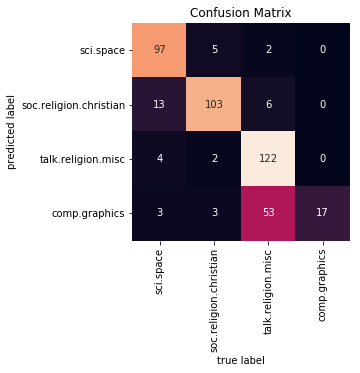

In [410]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [411]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.8901189440074644
0.7883720930232558
0.8175623673634485


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [412]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                     
soc.religion.christian  0.875569           0.649370    0.155814   0.666667   
comp.graphics           0.935671           0.789537    0.062791   0.829060   
talk.religion.misc      0.611842           0.360894    0.137209   1.000000   
sci.space               0.905897           0.813735    0.067442   0.911504   

                          Recall  
Category                          
soc.religion.christian  0.953125  
comp.graphics           0.932692  
talk.religion.misc      0.223684  
sci.space               0.844262

We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

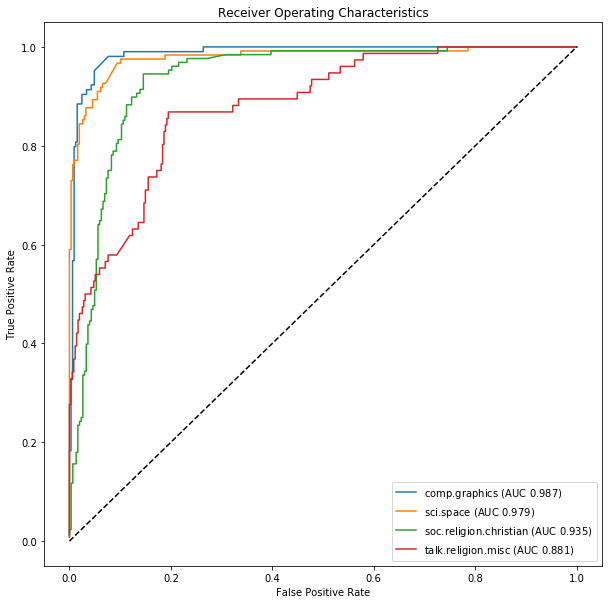

In [413]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

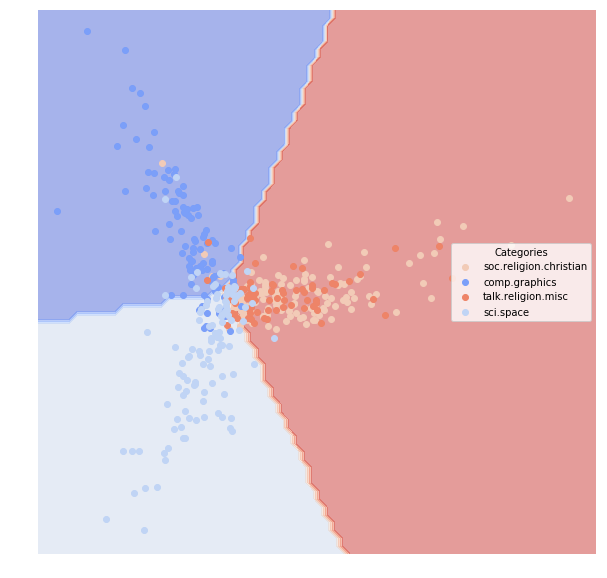

In [414]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

We can also give the model a new string, not present in our data, and use the *predict* method to see if it can assign it to a category. Using our model to extend its classifications to new, uncoded data might be the primary purpose of a social science application. The words do have to be in the vocabulary, so don't be too creative :-)

In [415]:
def predict_category(s, model, tfidf): #We just define a simple function here
    a = np.zeros((1, len(tfidf.vocabulary_)))
    for w in nltk.word_tokenize(s):
        try:
            a[:,tfidf.vocabulary_[lucem_illud.stemmer_basic.stem(w.lower())]] = 1
        except KeyError:
            print("Warning: '{}' not in vocabulary".format(w))
    return model.predict(a)[0]

In [416]:
predict_category('rockets are cool', MultinomialNB_ng, TFVectorizer_ng)

'sci.space'

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


The subset of project data that I am using in this assignment is 200 horror film plots that have showned after 2008 in the United States. The reason I am choosing to study horror film is because I am interested in studying: During the period of the Great Recession, were people more fond of horror films that feature monsters or horror films that feature people. Using MTurk, 100 of such film plots are labeled and in 0 or 1, and among which
- 0: films feature monsters such as vanpire or werewolves, dark magic such as curse or spells, viruses that transform people into mosters, and all other types of character that is supernatural. 
- 1: films feature soley humans (for example: mental or lunatic in killing or murdurous). 

## Prepare for data:  

Load horror movies coded and uncoded:

In [1505]:
horrorL = pandas.read_csv('../data/horrorWithLabels.csv') 
horrorNL = pandas.read_csv('../data/horrorNoLabels.csv')

Write a function that could apply model to uncoded data for future use:

In [1506]:
def uncodedClassification(model, uncodedDF):
    TFVects_uncoded = TFVectorizer.transform(uncodedDF['text'])
    uncodedDF['vect'] = [np.array(v).flatten() for v in TFVects_uncoded.todense()]
    uncodedDF['predict'] = model.predict(np.stack(uncodedDF['vect'], axis=0))
    return uncodedDF

Tokenize and normalize

In [1388]:
horrorL['tokenized_text'] = horrorL['text'].apply(lambda x: nltk.word_tokenize(x))
horrorL['normalized_text'] = horrorL['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Turn the 'category' column into a binary category variable. 

In [1389]:
horrorL['category'] = [s == 1 for s in horrorL['category']]

Split the data into training data and testing data.

In [1390]:
holdBackFraction = .2                                                        
train_data_df, test_data_df = lucem_illud.trainTestSplit(horrorL, holdBackFraction=holdBackFraction)

In [1391]:
print(train_data_df.shape)
print(test_data_df.shape)

(80, 7)
(20, 7)


## Logistic Regression 

Turn the training dataset into a tf-idf matrix. Due to the number of data that I have in my corpus, I have slightly tuned the parameter max_df and min_df so as to better adjust my data

In [1392]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=20, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Save this in the dataframe to make things easier

In [1393]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Implement a dimension reduction process PCA.

In [1394]:
pca = sklearn.decomposition.PCA()                                                  
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

Store the PCA space vectors in the dataframe too:

In [1395]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

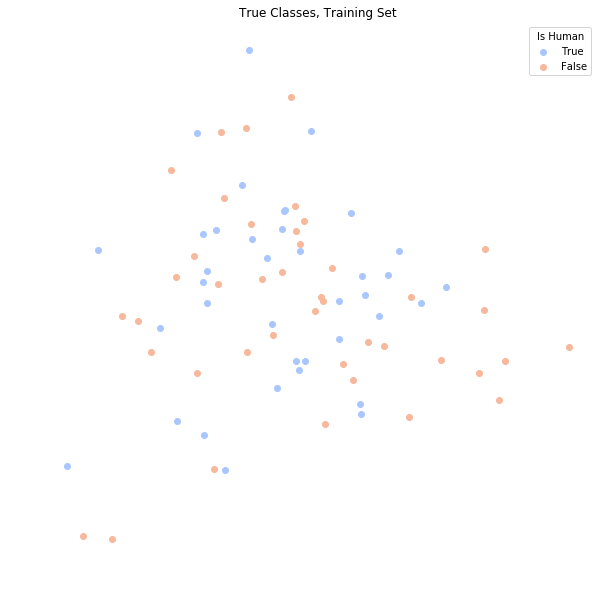

In [1396]:
fig, ax = plt.subplots(figsize = (10,10))                                       
ax.axis('off')                                                                  
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)                
#Plot Obama                                                                     
a = np.stack(train_data_df[train_data_df['category']]['pca'])                   
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")                      
#Plot not Obama                                                                 
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])         
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")                     
ax.legend(loc = 'upper right', title = 'Is Human')                              
plt.title('True Classes, Training Set')                                                        
plt.show()  

It seems PCA does not do a relatively good work distinguishing my dataset.

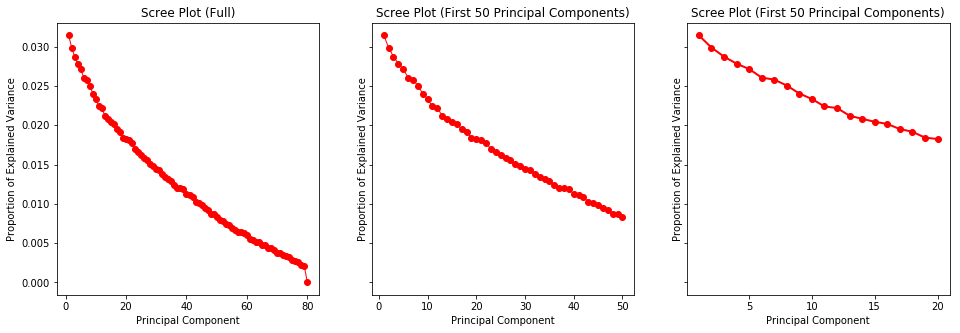

In [1397]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Looking at the scree plots above, it seems the majority of the variances is could be explained by the first 5 principle components. To prevent overfitting, I will first select first 5 principle components as my covariates

In [1398]:
train_data_df['pca_reduced_5'] = train_data_df['pca'].apply(lambda x: x[:5])              

Fit a logistic regression to our data, set the rate of regularization to be 0.2  

In [1399]:
logistic = sklearn.linear_model.LogisticRegression(C = 0.2)                                        
logistic.fit(np.stack(train_data_df['pca_reduced_5'], axis=0), train_data_df['category'])

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

See how the logistic regression performs on the training dataset from which we develop the model. The result is approximately 56.25% of accuracy, which is really bad...

In [1400]:
logistic.score(np.stack(train_data_df['pca_reduced_5'], axis=0), train_data_df['category'])

0.5625

Check its performance on the testing dataset: its about 50%, which means its just like guessing and hunches by us human.

In [1401]:
#Create vectors                                                                            
TFVects_test = TFVectorizer.transform(test_data_df['text'])                                
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]             
                                                                                           
#PCA                                                                                       
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))                  
test_data_df['pca'] = [r for r in reduced_data_test]                                       
test_data_df['pca_reduced_5'] = test_data_df['pca'].apply(lambda x: x[:5])               
                                                                                           
#Test                                                                                      
logistic.score(np.stack(test_data_df['pca_reduced_5'], axis=0), test_data_df['category'])

0.55

Create a model retaining only the most individually significant features, and the accuracy rates obtained from the training data is about 50%.

In [1402]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')                         
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])        
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.525


Train the model using training data, and then test it on the testing data, and the accuracy is 50%, slightly better than simple guessing. So, we could conclude logistic regression does not work well for my data set. 

In [1404]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])) 

0.5


Construct a performance metrics function to evaluate the model:

In [1405]:
def performanceMetrics(trainedModel, trainingDF, testingDF):                                                        
    # Visualize the confusion matrix for training and testing sets.             
    print('Confusion Matrix for training set')                                  
    lucem_illud.plotConfusionMatrix(trainedModel, trainingDF)                   
    print('Confusion Matrix for testing set')                                   
    lucem_illud.plotConfusionMatrix(trainedModel, testingDF)                    
                                                                                
                                                                                
    testingDF['predict'] = trainedModel.predict(np.stack(testingDF['vect'], axis=0))                      
    testingDF['predict_prob_true'] = trainedModel.predict_proba(np.stack(testingDF['vect'], axis=0))[:,0]
    # Calculate precision                                                       
    precision = sklearn.metrics.precision_score(testingDF['predict'], testingDF['category'])   
    print('Precision is: {}'.format(precision))   
    print()
    # Calculate recall                                                          
    recall = sklearn.metrics.recall_score(testingDF['predict'], testingDF['category'])
    print('Recall is: {}'.format(recall))                                      
    print()
    # Calculate F-measure                                                       
    fmeasure = sklearn.metrics.f1_score(testingDF['predict'], testingDF['category']) 
    print('F1-measure is: {}'.format(fmeasure))                                 
    print()
    # Calculate AUC                                                             
    print('AUC for each category is:')                                          
    auc = lucem_illud.evaluateClassifier(trainedModel, testingDF)              
    print(auc['AUC'])
    print()
    # ROC visulization.                                                         
    print('ROC Visualization')                                                  
    lucem_illud.plotMultiROC(trainedModel, testingDF)

Confusion Matrix for training set


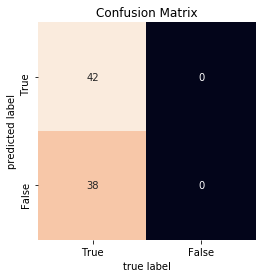

Confusion Matrix for testing set


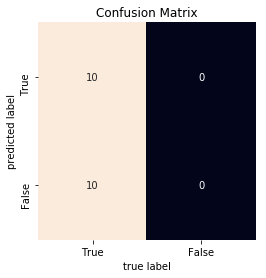

Precision is: 0.0

Recall is: 0.0

F1-measure is: 0.0

AUC for each category is:
Category
False    0.5
True     0.5
Name: AUC, dtype: float64

ROC Visualization


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


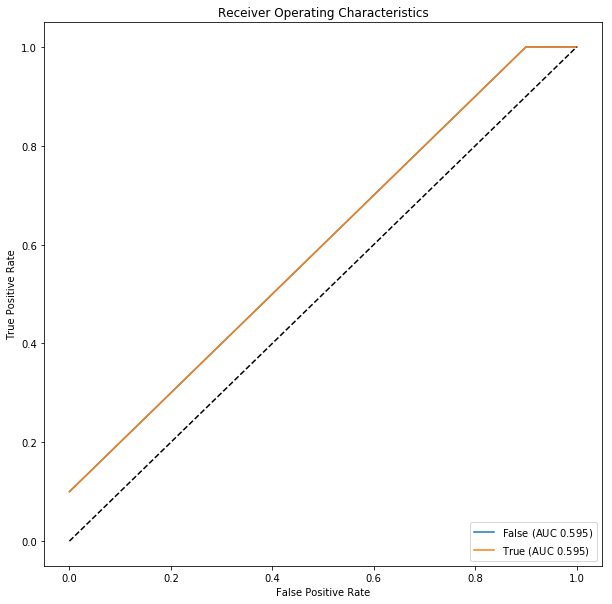

In [1406]:
performanceMetrics(logistic_l1, train_data_df, test_data_df)

### Performance Summary:

Looking at the performance metrics of the logistic regression model, unsurprisingly, this model does not perform the optimal. All performance metrics is 0 and this is because the error rate is about 50% meaning this is equivalent to random guesses so this model is just useless.

### Exrapolate codes from these models to all uncoded data.

Recall the function I have written in the very above:

In [1509]:
uncoded_logit = uncodedClassification(logistic_l1, horrorNL)

In [1510]:
uncoded_logit[100:106]

movie_id           title  year  \
100   3444042    Blood Canvas  2011   
101   3444062    Blood Colony  2008   
102   3444132   Blood Effects  2011   
103   3444186  Blood Guardian  2009   
104   3444259    Blood Island  2010   
105   3444268       Blood Kin  2011   

                                                  text  \
100  Simon (Fine Artist/Writer) invites his dear fr...   
101  Honolulu, Hawaii - Since the strange disappear...   
102  A fresh look at independent movie-making. Kris...   
103  Jason Hart witnesses the murder of his father ...   
104  Five friends head for Belize for the vacation ...   
105  A young woman tries to rebel against the inevi...   

                                                  vect  predict  
100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
101  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25070425...    False  
102  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
103  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
104  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
105  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False

## Naive Bayes

Train Naive Bayes model  

In [1407]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()                                                                      
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])   

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Assess prediction results applying to training set: among the 80 plots given the category, the prediction accuracy is 0.9 and the testing set, the prediction rate is 0.6

In [1408]:
print("Training:")                                                                                                  
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))                  
print("Testing:")                                                                                                   
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])) 

Training:
0.9375
Testing:
0.55


Confusion Matrix for training set


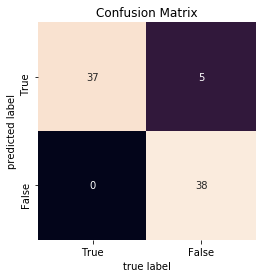

Confusion Matrix for testing set


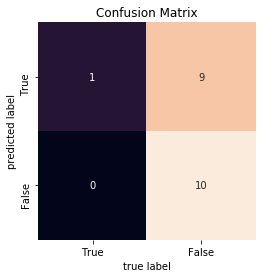

Precision is: 1.0

Recall is: 0.5263157894736842

F1-measure is: 0.6896551724137931

AUC for each category is:
Category
False    0.55
True     0.55
Name: AUC, dtype: float64

ROC Visualization


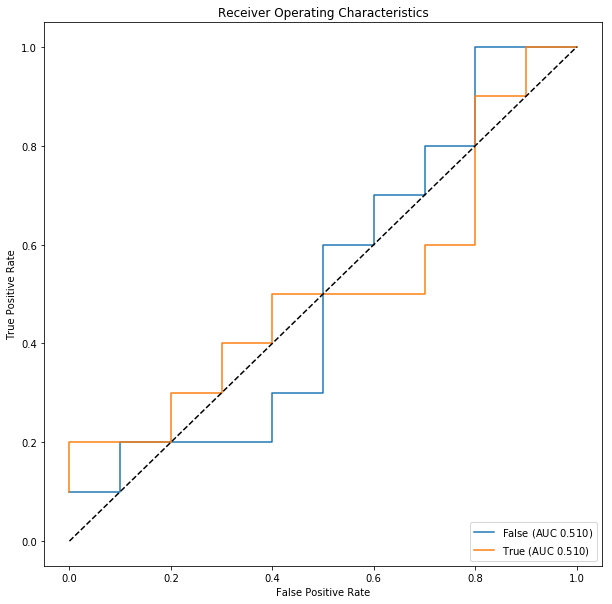

In [1409]:
performanceMetrics(naiveBayes, train_data_df, test_data_df)

Let's take a look at how well our posterior distribution looks relative to the truth.

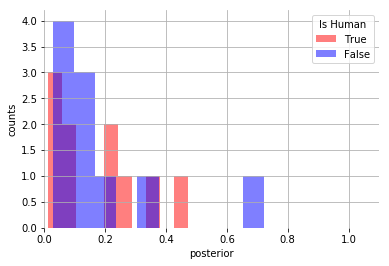

In [1410]:
fig, ax = plt.subplots()                                                                                            
ax.grid(False)                                                                                                      
ax.set_frame_on(False)                                                                                              
test_data_df[test_data_df['category'].eq(True)]['predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))                                                                                                
ax.legend(title = "Is Human")                                                                                       
ax.set_xlabel('posterior')                                                                                          
ax.set_ylabel('counts')                                                                                             
plt.show()  

### Performance Summary:

In conclusion, Naive Bayens performs slightly better than logistic regression model; however, there seems to be overfitting of data in the training set because there is high accuracy rate in the training set while relatively low performance in the testing set. In addition, several performance metrics also tells this overfitting: Precision is, impressively, 1.0, Recall is, 0.526, F1-measure is 0.689. I highly suspect the problems persisted in my model here is due to the size of the data.

### Exrapolate codes from these models to all uncoded data.

In [1511]:
uncoded_naivebayne = uncodedClassification(naiveBayes, horrorNL)

In [1512]:
uncoded_naivebayne[:5]

movie_id                               title  year  \
0   3359951                              Amused  2011   
1   3359952                           Amusement  2008   
2   3361481  An Evening with My Comatose Mother  2011   
3   3361648                   An Eye for an Eye  2010   
4   3365468               And Soon the Darkness  2010   

                                                text  \
0  After a lazy morning full of errands, Martha r...   
1  As retribution a psychopathic stalker known on...   
2  This is the story of Dorothy Pritchard and her...   
3  Jenni, (Vivian Uribe) a regular girl finds her...   
4  When two American girls on a bike trip in a re...   

                                                vect  predict  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
2  [0.0, 0.0, 0.09515494646722078, 0.0, 0.0, 0.0,...    False  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

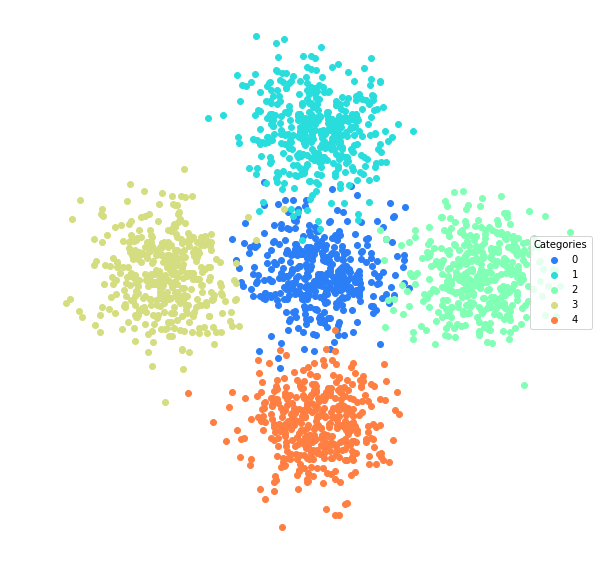

In [1411]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [1412]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

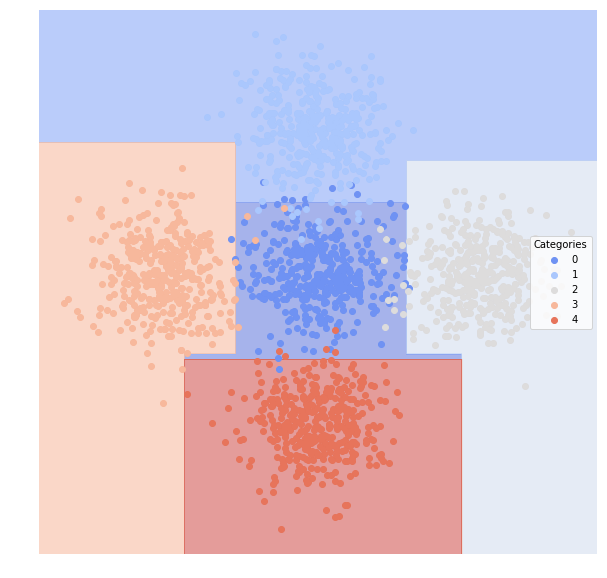

In [1413]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [1414]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
0         0.978524           0.898627       0.022   0.913462  0.979381
1         0.995050           0.992099       0.002   1.000000  0.990099
2         0.985849           0.977698       0.006   1.000000  0.971698
3         0.997487           0.980769       0.004   0.980769  1.000000
4         0.973404           0.956809       0.010   1.000000  0.946809

Lets look at accuracy:

In [1415]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.978

What happens if we trim the tree?

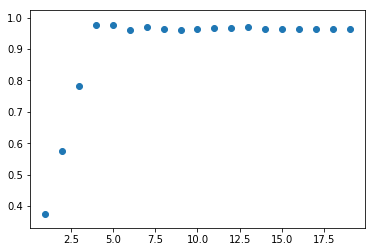

In [1416]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [1417]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [1418]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

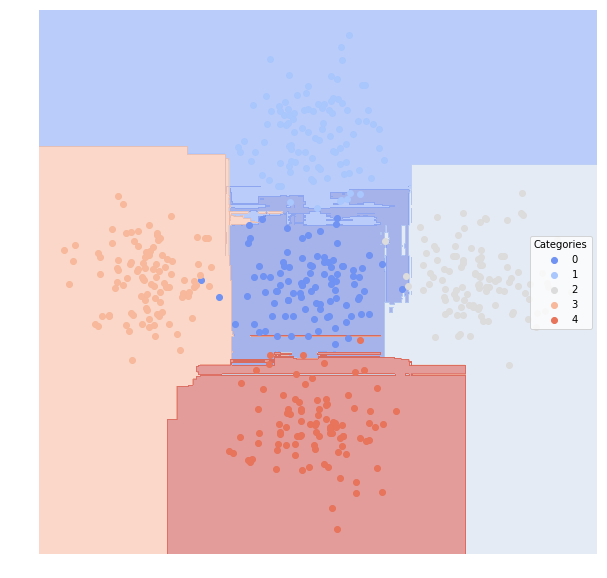

In [1419]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [1420]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
0         0.966974           0.873679       0.028   0.902913  0.958763
1         0.980198           0.968396       0.008   1.000000  0.960396
2         0.990566           0.985132       0.004   1.000000  0.981132
3         0.997487           0.980769       0.004   0.980769  1.000000
4         0.976260           0.944633       0.012   0.978261  0.957447

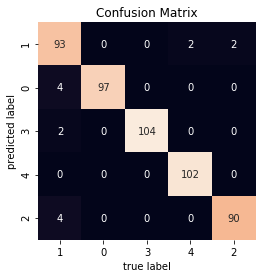

In [1421]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

## Decision Tree Classification:

Initialize and train the model

In [1514]:
horror_tree = sklearn.tree.DecisionTreeClassifier(max_depth=12,random_state=0)   
horror_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Visualize the classification

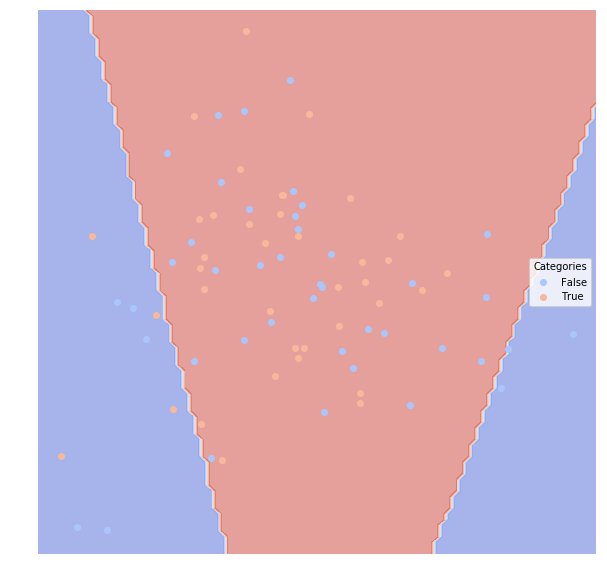

In [1515]:
lucem_illud.plotregions(horror_tree, train_data_df)

Evaluate the model:

In [1516]:
lucem_illud.evaluateClassifier(horror_tree, train_data_df)

AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                             
False     0.97619           0.977381       0.025       1.00  0.952381
True      0.97619           0.950000       0.025       0.95  1.000000

Accuracy:the accuracy score that I have obtained is 0.65 after applying to the test data! Tree method is a lot better than logistic regression model and naive bayne model.

In [1517]:
sklearn.metrics.accuracy_score(test_data_df['category'],
                               horror_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.65

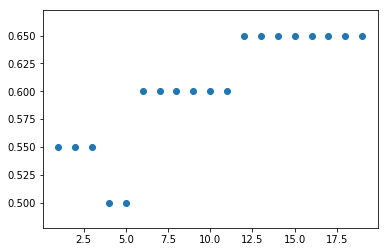

In [1458]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

Confusion Matrix for training set


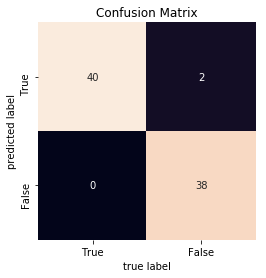

Confusion Matrix for testing set


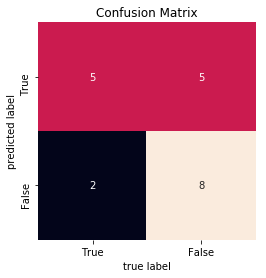

Precision is: 0.8

Recall is: 0.6153846153846154

F1-measure is: 0.6956521739130435

AUC for each category is:
Category
False    0.65
True     0.65
Name: AUC, dtype: float64

ROC Visualization


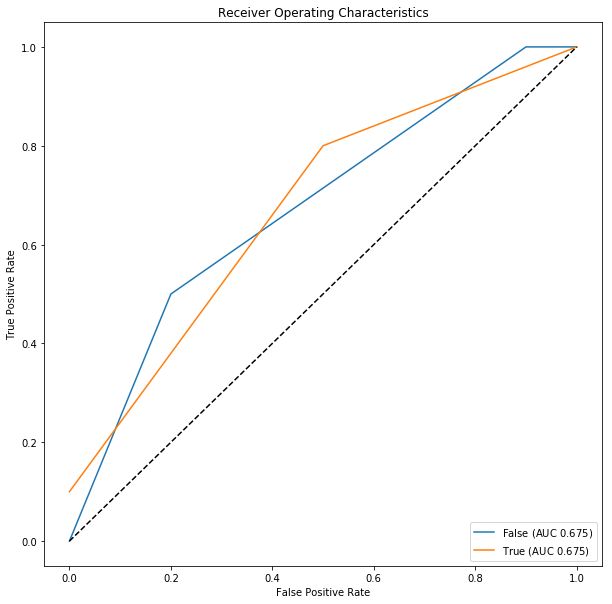

In [1518]:
performanceMetrics(horror_tree, train_data_df, test_data_df)

### Exrapolate codes from these models to all uncoded data

In [1603]:
uncoded_tree = uncodedClassification(horror_tree, horrorNL)
uncoded_tree[:5]

movie_id                               title  year  \
0   3359951                              Amused  2011   
1   3359952                           Amusement  2008   
2   3361481  An Evening with My Comatose Mother  2011   
3   3361648                   An Eye for an Eye  2010   
4   3365468               And Soon the Darkness  2010   

                                                text  \
0  After a lazy morning full of errands, Martha r...   
1  As retribution a psychopathic stalker known on...   
2  This is the story of Dorothy Pritchard and her...   
3  Jenni, (Vivian Uribe) a regular girl finds her...   
4  When two American girls on a bike trip in a re...   

                                                vect  predict  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
2  [0.0, 0.0, 0.09515494646722078, 0.0, 0.0, 0.0,...     True  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True

### Performance Summary

In conclusion, tree model performs to be better than logistic regression model and Naive Baynes; however, there seems to be slight overfitting of data in the training set that needs to be tuned because there is high accuracy rate in the training set while relatively low performance, comparing with the training set, in the testing set. In addition, several performance metrics also tells this overfitting: Precision is, impressively, 0.61, Recall is, 0.62, F1-measure is 0.70. 

## Random Forest Classification

Initialize and train the model: I have tuned the parameter times and I discovered when the number of estimators to be 30 and use half the sample to train the data, it would perform the best.

In [1502]:
horror_tree = sklearn.tree.DecisionTreeClassifier(max_depth=12) 
horror_bag = sklearn.ensemble.BaggingClassifier(horror_tree, n_estimators=30, max_samples=0.5, random_state=1) #Each tree uses up to 80% of the data

Train the model using the training data

In [1503]:
horror_bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5, n_estimators=30, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

Visualization of classification: it could be seen that it is almost an andSplit format.

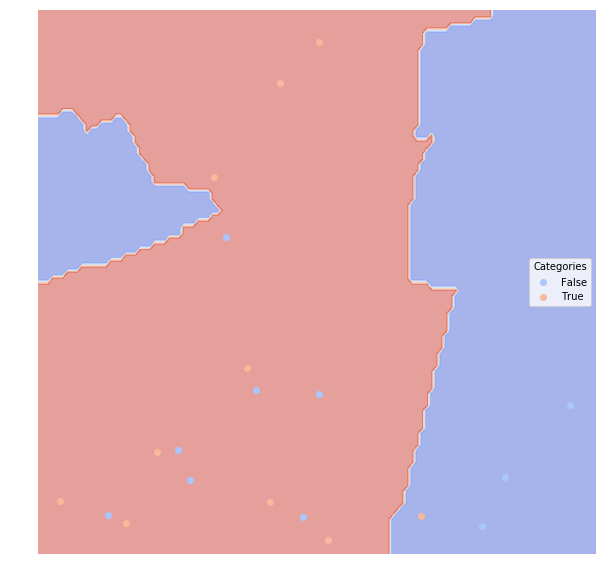

In [1504]:
lucem_illud.plotregions(horror_bag, test_data_df)

Evaluate the model again:

In [1499]:
lucem_illud.evaluateClassifier(horror_bag, test_data_df)

AUC  Average_Precision  Error_Rate  Precision  Recall
Category                                                        
False     0.75           0.750000        0.25   1.000000     0.5
True      0.75           0.666667        0.25   0.666667     1.0

Check the accuracy score:

In [1500]:
sklearn.metrics.accuracy_score(test_data_df['category'],
                               horror_bag.predict(np.stack(test_data_df['vect'], axis = 0)))

0.75

Confusion Matrix for training set


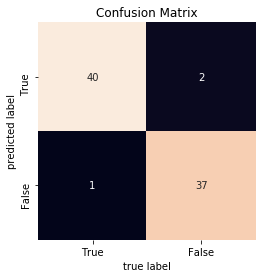

Confusion Matrix for testing set


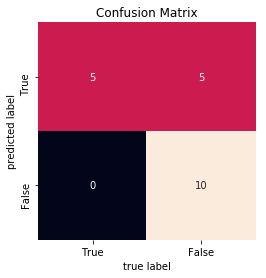

Precision is: 1.0

Recall is: 0.6666666666666666

F1-measure is: 0.8

AUC for each category is:
Category
False    0.75
True     0.75
Name: AUC, dtype: float64

ROC Visualization


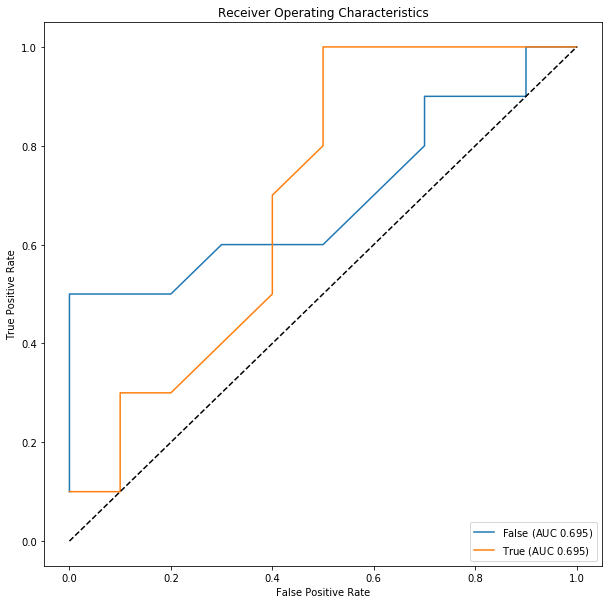

In [1501]:
performanceMetrics(horror_bag, train_data_df, test_data_df)

### Exrapolate codes from these models to all uncoded data

In [1570]:
uncoded_bagging = uncodedClassification(horror_bag, horrorNL)
uncoded_bagging[:5]

movie_id                               title  year  \
0   3359951                              Amused  2011   
1   3359952                           Amusement  2008   
2   3361481  An Evening with My Comatose Mother  2011   
3   3361648                   An Eye for an Eye  2010   
4   3365468               And Soon the Darkness  2010   

                                                text  \
0  After a lazy morning full of errands, Martha r...   
1  As retribution a psychopathic stalker known on...   
2  This is the story of Dorothy Pritchard and her...   
3  Jenni, (Vivian Uribe) a regular girl finds her...   
4  When two American girls on a bike trip in a re...   

                                                vect  predict  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
2  [0.0, 0.0, 0.09515494646722078, 0.0, 0.0, 0.0,...    False  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True

### Performance Summary

So far, bagging is the best performing method among models previously presented: logistic, Naive Bayne, and tree model with a dominating accuracy rate of 75% on the testing set. Some summary statistics of the model is: Precision is 1.0, recall is: 0.67, and F1-measure is: 0.8. So far, I think this is the best performing method that worth to further tuning. 

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [1521]:
newsgroupsDF[:5]

category                                        source_file  \
0  talk.religion.misc  /Users/Reid/scikit_learn_data/20news_home/20ne...   
1  talk.religion.misc  /Users/Reid/scikit_learn_data/20news_home/20ne...   
2  talk.religion.misc  /Users/Reid/scikit_learn_data/20news_home/20ne...   
3  talk.religion.misc  /Users/Reid/scikit_learn_data/20news_home/20ne...   
4  talk.religion.misc  /Users/Reid/scikit_learn_data/20news_home/20ne...   

                                                text  \
0  \n\nParadise and salvation are not the same th...   
1  \nYou're admitting a lot more than that.  You ...   
2  \n\nJesus also recognized other holy days, lik...   
3  In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...   
4  \nI'm sorry, but He does not!  Ever read the F...   

                                      tokenized_text  \
0  [Paradise, and, salvation, are, not, the, same...   
1  [You, 're, admitting, a, lot, more, than, that...   
2  [Jesus, also, recognized, other, holy, days, ,...   
3  [In, <, lsjc8cINNmc1, @, saltillo.cs.utexas.ed...   
4  [I, 'm, sorry, ,, but, He, does, not, !, Ever,...   

                                     normalized_text  
0  [paradis, salvat, thing, salvat, better, refer...  
1  [admit, lot, admit, moral, situat, admit, acti...  
2  [jesus, also, recogn, holi, day, like, passov,...  
3  [turpin, russel, turpin, regard, love, less, b...  
4           [sorri, doe, ever, read, first, command]

Make a testing and training set:

In [1522]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [1523]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [1524]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [1525]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [1526]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

AUC  Average_Precision  Error_Rate  Precision  \
Category                                                                     
soc.religion.christian  0.517172           0.311767    0.277423   1.000000   
comp.graphics           0.726623           0.415994    0.327916   0.442938   
talk.religion.misc      0.612846           0.226857    0.273941   0.297483   
sci.space               0.669151           0.413261    0.239698   0.572917   

                          Recall  
Category                          
soc.religion.christian  0.034343  
comp.graphics           0.844828  
talk.religion.misc      0.440678  
sci.space               0.469083

And lets look at the testing data

In [1527]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2744186046511628


Let's produce another confusion matrix:

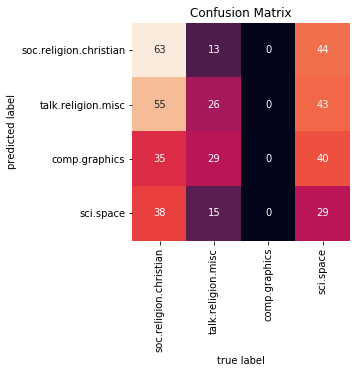

In [1528]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

## K-nearest neighbor classification

Initialize the model

In [1572]:
n_neighbors = 15                                                                  
weights="uniform"                                                                  
horror_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Train the model 

In [1573]:
horror_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

Visualization of classification

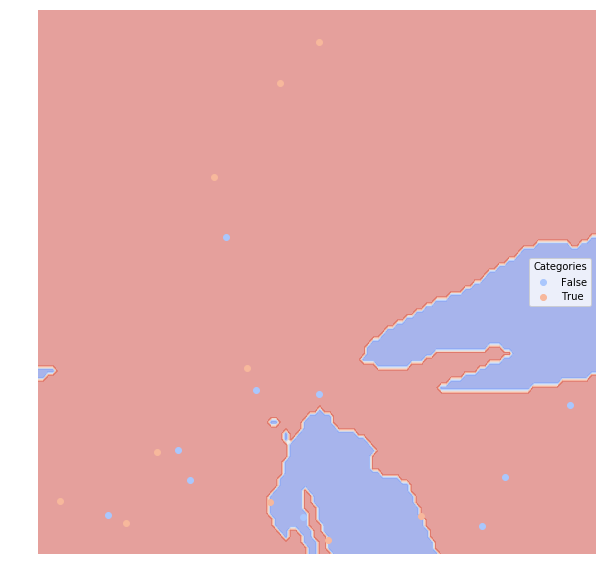

In [1574]:
lucem_illud.plotregions(horror_knearest, test_data_df)

Evaluate classifier                                                           

In [1575]:
lucem_illud.evaluateClassifier(horror_knearest, test_data_df)     

AUC  Average_Precision  Error_Rate  Precision  Recall
Category                                                       
False     0.6           0.558333         0.4   0.583333     0.7
True      0.6           0.562500         0.4   0.625000     0.5

Check acuuracy acore:

In [1576]:
sklearn.metrics.accuracy_score(test_data_df['category'],
                               horror_knearest.predict(np.stack(test_data_df['vect'], axis = 0)))

0.6

Evaluate all performance metrics

Confusion Matrix for training set


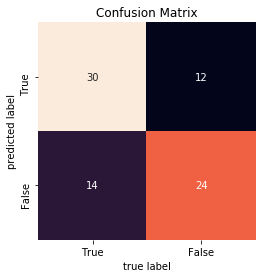

Confusion Matrix for testing set


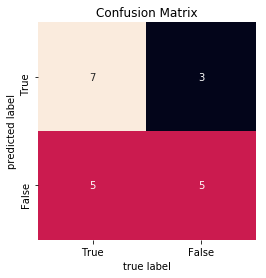

Precision is: 0.5

Recall is: 0.625

F1-measure is: 0.5555555555555556

AUC for each category is:
Category
False    0.6
True     0.6
Name: AUC, dtype: float64

ROC Visualization


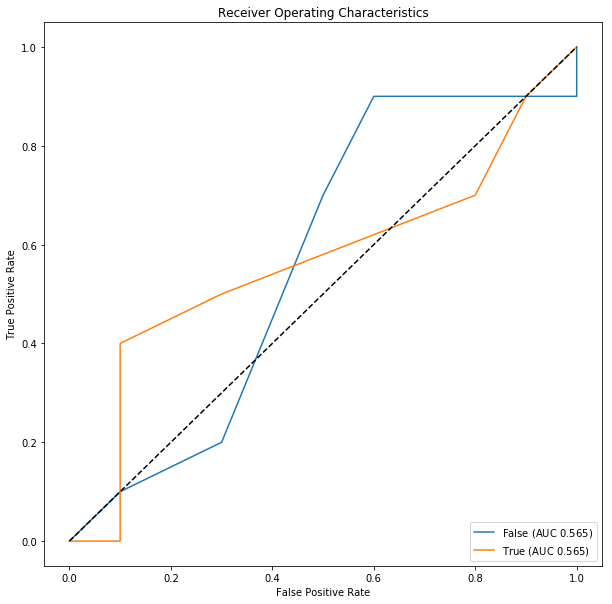

In [1577]:
performanceMetrics(horror_knearest, train_data_df, test_data_df)

### Exrapolate codes from these models to all uncoded data

In [1571]:
uncoded_knn = uncodedClassification(clf_knearest, horrorNL)
uncoded_bagging[:5]

movie_id                               title  year  \
0   3359951                              Amused  2011   
1   3359952                           Amusement  2008   
2   3361481  An Evening with My Comatose Mother  2011   
3   3361648                   An Eye for an Eye  2010   
4   3365468               And Soon the Darkness  2010   

                                                text  \
0  After a lazy morning full of errands, Martha r...   
1  As retribution a psychopathic stalker known on...   
2  This is the story of Dorothy Pritchard and her...   
3  Jenni, (Vivian Uribe) a regular girl finds her...   
4  When two American girls on a bike trip in a re...   

                                                vect  predict  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
2  [0.0, 0.0, 0.09515494646722078, 0.0, 0.0, 0.0,...    False  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False

### Performance summary:

KNN acutually is performing relatively well with approximately 60% of accuracy rate on the testing set. It is definitely better than logistic regression model, Native Bayne model, and the tree model but inferior to bagging method. According to some summary statistics, precision score is 0.5, recall is 0.625, and F1-measure is 0.56. In conclusion, I think this model also fits my data well so I think this model also worth for further tuning. 

### Potential differences between K-nearest neighbor and K-mean clustering?

Both KNN approach and k-means clustering have to do with how are they going to use the k number of neighbors or clusters each single data points locates. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. K-nearest neighbors algorithm is a type of pattern recognization algrotihm and it aims to classify objects by a majority vote of its K neighbors, with the object being assigned to the class most common among its k nearest neighbors.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [1550]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

We will tf.idf the data to make our vectors:

In [1551]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [1552]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [1553]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

...and consider the results:

In [1554]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

AUC  \
Category                                                       
Bad Roommates: Tales of Irritation                  0.993644   
Weeaboo Tales: stories about the extreme fans o...  0.977142   
Tales From Tech Support                             0.997872   
Relationships                                       0.979158   

                                                    Average_Precision  \
Category                                                                
Bad Roommates: Tales of Irritation                           0.965116   
Weeaboo Tales: stories about the extreme fans o...           0.954047   
Tales From Tech Support                                      0.988235   
Relationships                                                0.959565   

                                                    Error_Rate  Precision  \
Category                                                                    
Bad Roommates: Tales of Irritation                    0.009404   0.965116   
Weeaboo Tales: stories about the extreme fans o...    0.012539   0.985714   
Tales From Tech Support                               0.003135   0.988235   
Relationships                                         0.012539   0.987179   

                                                      Recall  
Category                                                      
Bad Roommates: Tales of Irritation                  1.000000  
Weeaboo Tales: stories about the extreme fans o...  0.958333  
Tales From Tech Support                             1.000000  
Relationships                                       0.962500

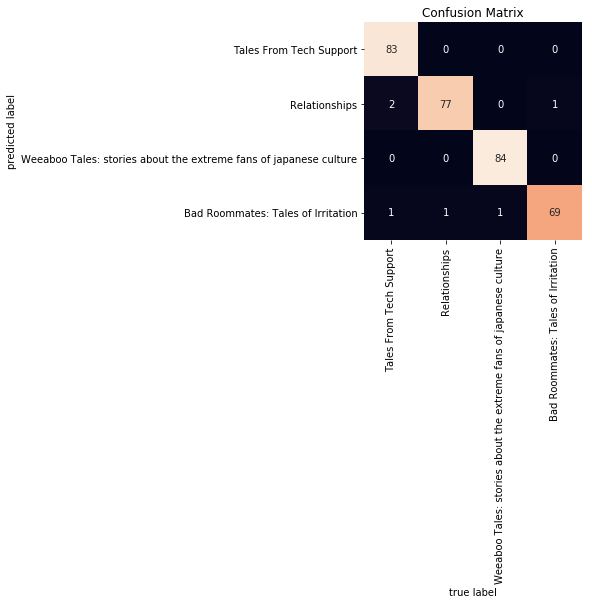

In [1555]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

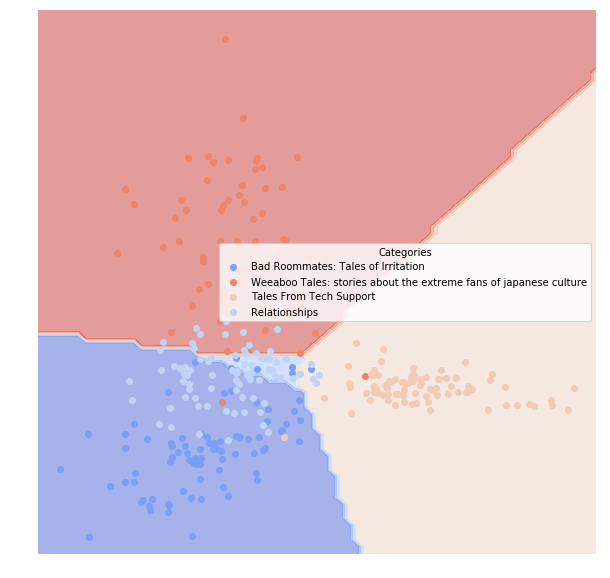

In [1556]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# <span style="color:red"> SVM Implementation on my project data set

Initilize the model and train the model:

In [1579]:
horror_svm = sklearn.svm.SVC(kernel='linear', probability = True)
#probability = True is slower but  lets you call predict_proba()
horror_svm.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Visualization of classification

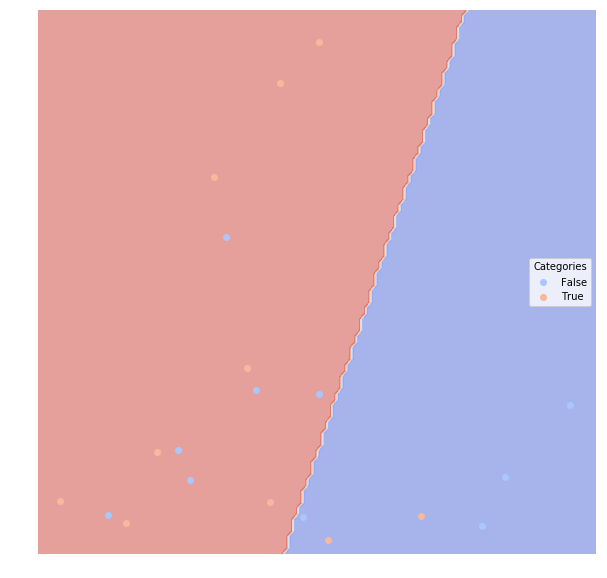

In [1580]:
lucem_illud.plotregions(horror_svm, test_data_df)

Evaluate classifier:

In [1581]:
lucem_illud.evaluateClassifier(horror_svm, test_data_df)     

AUC  Average_Precision  Error_Rate  Precision  Recall
Category                                                        
False     0.45           0.477778        0.55   0.444444     0.4
True      0.45           0.477273        0.55   0.454545     0.5

Check accuracy rate from my testing set

In [1582]:
sklearn.metrics.accuracy_score(test_data_df['category'],
                               horror_svm.predict(np.stack(test_data_df['vect'], axis = 0)))

0.45

Evaluate all performance metrics:

Confusion Matrix for training set


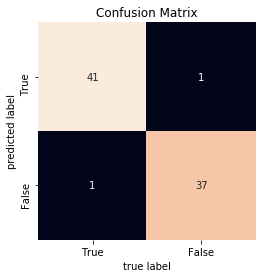

Confusion Matrix for testing set


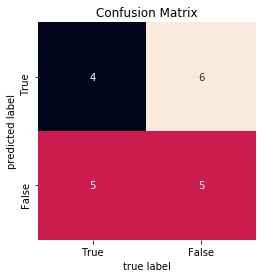

Precision is: 0.5

Recall is: 0.45454545454545453

F1-measure is: 0.47619047619047616

AUC for each category is:
Category
False    0.45
True     0.45
Name: AUC, dtype: float64

ROC Visualization


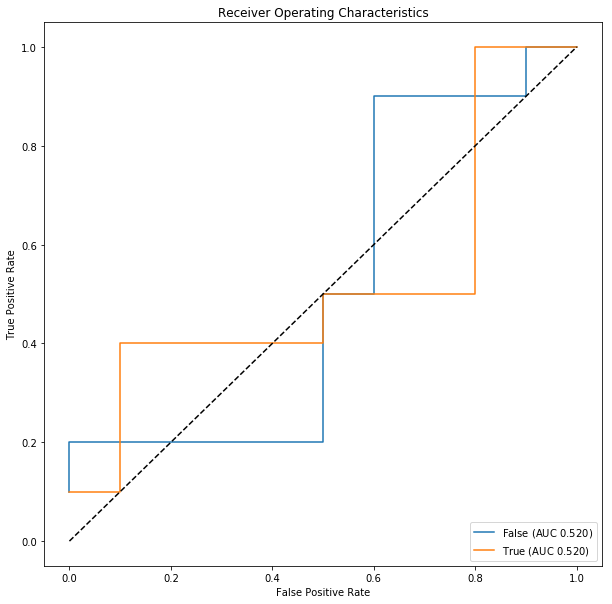

In [1583]:
performanceMetrics(horror_svm, train_data_df, test_data_df)

### Exrapolate codes from these models to all uncoded data

In [1585]:
uncoded_svm = uncodedClassification(horror_svm, horrorNL)
uncoded_svm[:5]

movie_id                               title  year  \
0   3359951                              Amused  2011   
1   3359952                           Amusement  2008   
2   3361481  An Evening with My Comatose Mother  2011   
3   3361648                   An Eye for an Eye  2010   
4   3365468               And Soon the Darkness  2010   

                                                text  \
0  After a lazy morning full of errands, Martha r...   
1  As retribution a psychopathic stalker known on...   
2  This is the story of Dorothy Pritchard and her...   
3  Jenni, (Vivian Uribe) a regular girl finds her...   
4  When two American girls on a bike trip in a re...   

                                                vect  predict  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
2  [0.0, 0.0, 0.09515494646722078, 0.0, 0.0, 0.0,...    False  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False

### Performance metrics evaluation:

SVM with linear kernal does not seem to be an appropriate model to use for my data as the accuracy rate on the testing set is merely 45%. This is rediculous because the model performs even worse than guesses and hunches. I think maybe the reasons for this bad performance is the quality of data and the tunning process of the prarmeters. 

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [1586]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [1587]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

AUC  \
Category                                                       
Bad Roommates: Tales of Irritation                  0.971003   
Weeaboo Tales: stories about the extreme fans o...  0.980038   
Tales From Tech Support                             0.994048   
Relationships                                       0.954158   

                                                    Average_Precision  \
Category                                                                
Bad Roommates: Tales of Irritation                           0.894452   
Weeaboo Tales: stories about the extreme fans o...           0.938537   
Tales From Tech Support                                      0.991230   
Relationships                                                0.922112   

                                                    Error_Rate  Precision  \
Category                                                                    
Bad Roommates: Tales of Irritation                    0.031348   0.910112   
Weeaboo Tales: stories about the extreme fans o...    0.015674   0.958904   
Tales From Tech Support                               0.003135   1.000000   
Relationships                                         0.025078   0.986486   

                                                      Recall  
Category                                                      
Bad Roommates: Tales of Irritation                  0.975904  
Weeaboo Tales: stories about the extreme fans o...  0.972222  
Tales From Tech Support                             0.988095  
Relationships                                       0.912500

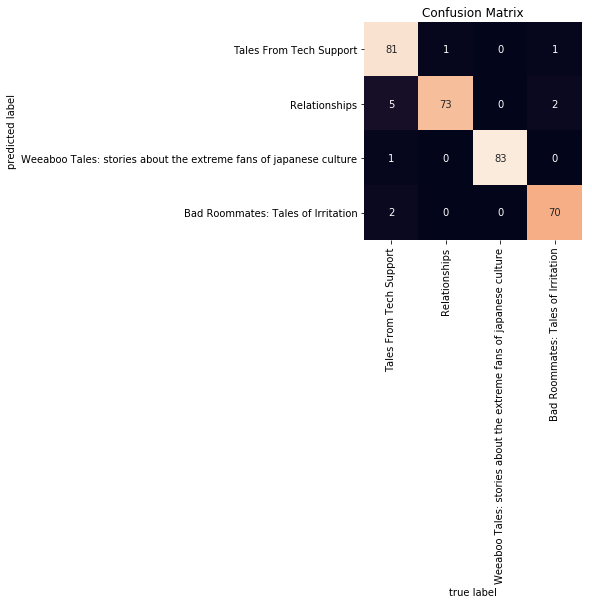

In [1588]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

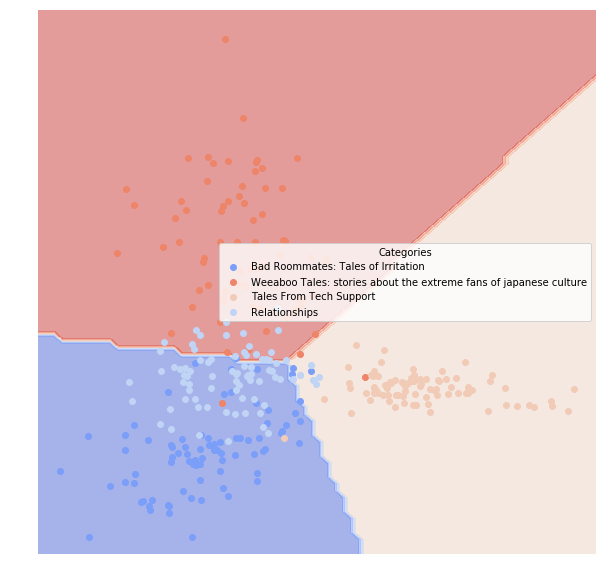

In [1589]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

# Neural Network Classification

Initialize and train the model using training data

In [1596]:
horror_nn = sklearn.neural_network.MLPClassifier(solver='lbfgs', hidden_layer_sizes=[100], max_iter=2000, activation='logistic')
horror_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[100], learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Visualization of classification

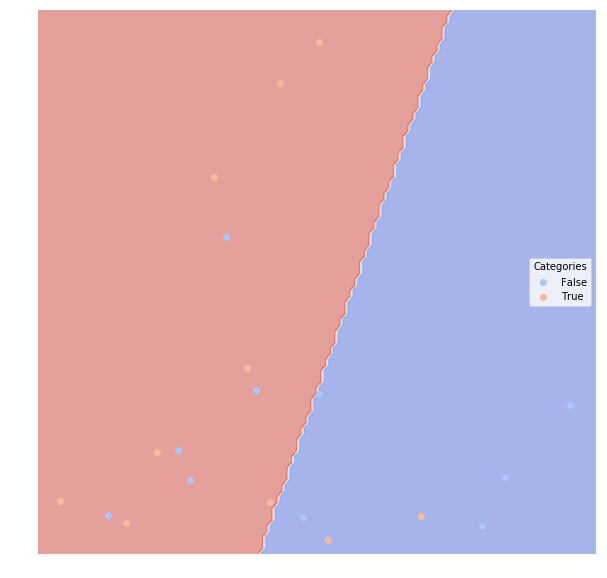

In [1597]:
lucem_illud.plotregions(horror_nn, test_data_df)

Evaluate classifier:

In [1598]:
lucem_illud.evaluateClassifier(horror_nn, test_data_df)     

AUC  Average_Precision  Error_Rate  Precision  Recall
Category                                                        
False     0.55           0.527778        0.45   0.555556     0.5
True      0.55           0.527273        0.45   0.545455     0.6

Check accuracy rate from my testing set

In [1599]:
sklearn.metrics.accuracy_score(test_data_df['category'],
                               horror_nn.predict(np.stack(test_data_df['vect'], axis = 0)))

0.55

Evaluate all performance metrics:

Confusion Matrix for training set


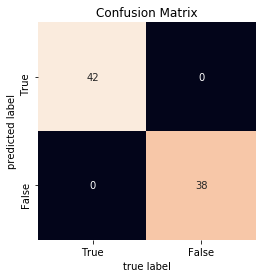

Confusion Matrix for testing set


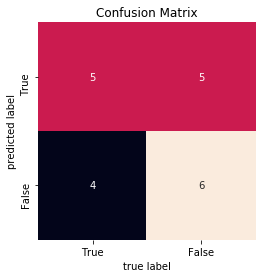

Precision is: 0.6

Recall is: 0.5454545454545454

F1-measure is: 0.5714285714285713

AUC for each category is:
Category
False    0.55
True     0.55
Name: AUC, dtype: float64

ROC Visualization


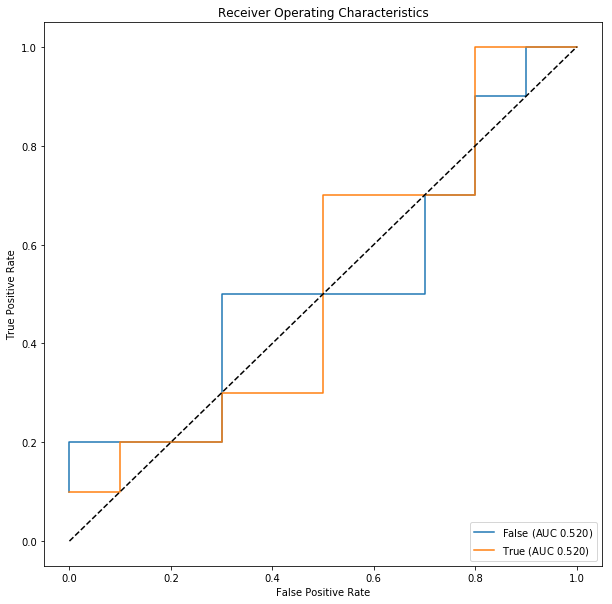

In [1600]:
performanceMetrics(horror_nn, train_data_df, test_data_df)

### Extrapolate codes from these models to all uncoded data

In [1601]:
uncoded_nn = uncodedClassification(horror_nn, horrorNL)
uncoded_nn[:5]

movie_id                               title  year  \
0   3359951                              Amused  2011   
1   3359952                           Amusement  2008   
2   3361481  An Evening with My Comatose Mother  2011   
3   3361648                   An Eye for an Eye  2010   
4   3365468               And Soon the Darkness  2010   

                                                text  \
0  After a lazy morning full of errands, Martha r...   
1  As retribution a psychopathic stalker known on...   
2  This is the story of Dorothy Pritchard and her...   
3  Jenni, (Vivian Uribe) a regular girl finds her...   
4  When two American girls on a bike trip in a re...   

                                                vect  predict  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     True  
2  [0.0, 0.0, 0.09515494646722078, 0.0, 0.0, 0.0,...    False  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    False

### Performance metrics evaluation:

Using the Neural Network classification model, the accuracy rate of the testing set is approximately 55%, only slightly better than ramdomly guessing. The precision score is 0.6, recall score is 0.55, and the F1-measure is 0.57. Thus, nueral network model is a an okay model for my data set but there were better options. 

### Conclusion

How does this classify relevant to k-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

Comparing with logistic regression model, Naive Bayen, decision tree, random forest, bagging, KNN, and SVM, I think that random forest bagging method is the optimal algorithm works the best for my chosen project dataset with a high accuracy of 75% on my testing set without refined tuning. Logistic regression model and SVM are the two worst performing models that I think does not apply to my data set well. In addition, decision tree and KNN are relatively well-performing and could potentially compete with Bagging if fine-tuned. 